In [1]:
import pdb
from functools import partial
from typing import Callable

import einops
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
from jaxtyping import PRNGKeyArray, PyTreeDef
from tqdm import tqdm

from diffuse.mixture import init_mixture, sampler_mixtr
from diffuse.neural_networks import MLP
from diffuse.score_matching import score_match_loss
from diffuse.sde import SDE, LinearSchedule, SDEState
from diffuse.unet import UNet
#from diffuse.conditional import generate_cond_sample, pmcmc, pmcmc_step, CondSDE
from diffuse.images import measure, SquareMask, restore

import matplotlib.pyplot as plt
def plotter_line(array):
    total_frames = len(array)

    # Define the fractions
    fractions = [0., 0.01, 0.05, .1, 0.3, 0.5, 0.9, .95, 1.]
    n = len(fractions)
    # Create a figure with subplots
    fig, axs = plt.subplots(1, n, figsize=(n*3, n))
    
    for idx, fraction in enumerate(fractions):
        # Calculate the frame index
        frame_index = int(fraction * total_frames)
        
        # Plot the image
        axs[idx].imshow(array[frame_index], cmap="gray")
        axs[idx].set_title(f"Frame at {fraction*100}% of total")
        axs[idx].axis('off')  # Turn off axis labels
        
    plt.tight_layout()
    plt.show()


def top_5_percent_indices(arr):
    n = int(len(arr) * 0.05)  # Calculate 5% of the array length
    return jnp.argsort(arr)[-n:][::-1]  # Return indices of top 5% values in descending order


def bottom_5_percent_indices(arr):
    n = max(1, int(len(arr) * 0.05))  # Calculate 5% of the array length, minimum 1
    return jnp.argsort(arr)[:n] 

%load_ext autoreload
%autoreload 2

In [2]:
data = jnp.load("dataset/mnist.npz")
key = jax.random.PRNGKey(0)
xs = data["X"]

xs = jax.random.permutation(key, xs, axis=0)
data = einops.rearrange(xs, "b h w -> b h w 1")

tf = 2.0
batch_size = 256
n_epochs = 3000
n_t = 256
dt = tf / n_t

beta = LinearSchedule(b_min=0.02, b_max=5.0, t0=0.0, T=tf)
sde = SDE(beta)

nn_unet = UNet(dt, 64, upsampling="pixel_shuffle")

In [3]:
nn_trained = jnp.load("ann_2999.npz", allow_pickle=True)
nn_params = nn_trained["params"].item()
# nn_params = nn_unet.init(key, jnp.ones((batch_size, 28, 28, 1)), jnp.ones((batch_size, )))
array_param, array_to_dict = jax.flatten_util.ravel_pytree(nn_params)

# test other implementation
# nn_trained = jnp.load("mnist_lin_2999.npz", allow_pickle=True)
# nn_params = nn_trained["param"]
# nn_params = array_to_dict(nn_params)

In [4]:
def nn_score(x, t):
    return nn_unet.apply(nn_params, x, t)

In [10]:
n_steps = 100
rng_key = jax.random.PRNGKey(0)

ts = jnp.array([tf])
dts = jnp.array([2.0 / n_steps] * (n_steps))

beta = LinearSchedule(b_min=0.02, b_max=5.0, t0=0.0, T=2.0)
sde = SDE(beta=beta)

init_samples = jax.random.normal(rng_key, data[0].shape)
state_f = SDEState(position=init_samples, t=ts)

revert_sde = partial(sde.reverso, score=nn_score, dts=dts)
state_0, state_Ts = revert_sde(rng_key, state_f)

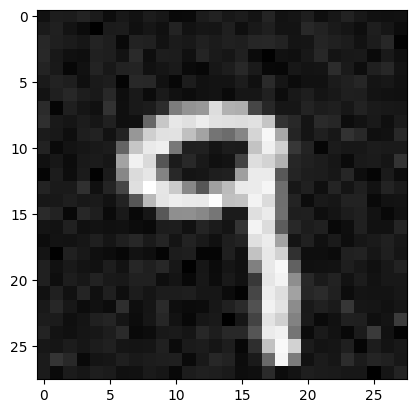

In [11]:
plt.imshow(state_Ts.position[-1], cmap="gray")
plt.show()

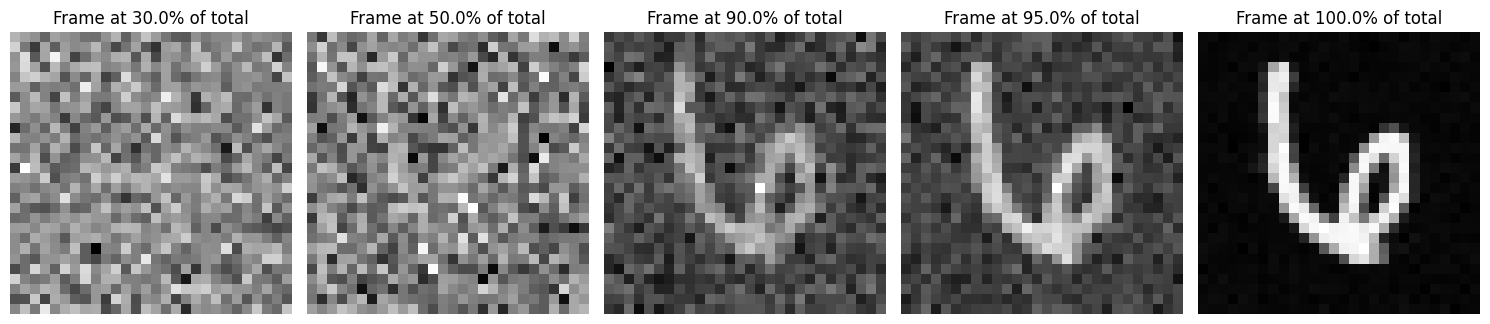

In [11]:
total_frames = len(state_Ts.position)

# Define the fractions
fractions = [0.3, 0.5, 0.9, 0.95, 1.0]

# Create a figure with subplots
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

for idx, fraction in enumerate(fractions):
    # Calculate the frame index
    frame_index = int(fraction * total_frames)

    # Plot the image
    axs[idx].imshow(state_Ts.position[frame_index], cmap="gray")
    axs[idx].set_title(f"Frame at {fraction*100}% of total")
    axs[idx].axis("off")  # Turn off axis labels

plt.tight_layout()
plt.show()

In [8]:
x = xs[0]
mask = SquareMask(10, x.shape)
# x = state_Ts.position[-1]
xi = jnp.array([10.0, 20.0])
y = measure(xi, x, mask)
cond_sde = CondSDE(beta=beta, mask=mask, tf=2.0, score=nn_score)

res = generate_cond_sample(y, xi, key, 100, cond_sde, x.shape)

NameError: name 'CondSDE' is not defined

# Conditional generation

In [9]:
import jax
import jax.numpy as jnp
from diffuse.sde import SDE, LinearSchedule
from diffuse.images import SquareMask, measure
from diffuse.conditional import CondSDE, CondState
from diffuse.filter import generate_cond_sample
from diffuse.unet import UNet
import numpy as np

# Load MNIST dataset
data = np.load("dataset/mnist.npz")
xs = jnp.array(data["X"])
xs = xs.reshape(xs.shape[0], xs.shape[1], xs.shape[2], 1)  # Add channel dimension
batch_size = 2
tf = 2.0
batch_size = 256
n_epochs = 3000
n_t = 256
dt = tf / n_t

# Initialize PRNGKey
key = jax.random.PRNGKey(0)

# Define beta schedule
beta = LinearSchedule(b_min=0.02, b_max=5.0, t0=0.0, T=2.0)

# Initialize ScoreNetwork (assuming you have this defined elsewhere)
score_net = UNet(dt, 64, upsampling="pixel_shuffle")
#params = score_net.init(key, jnp.ones((batch_size, 28, 28, 1)), jnp.ones((batch_size,)))
nn_trained = jnp.load("ann_2999.npz", allow_pickle=True)
params = nn_trained["params"].item()


# Define neural network score function
def nn_score(x, t):
    return score_net.apply(params, x, t)


# SDE setup
sde = SDE(beta=beta)


x = xs[0]
mask = SquareMask(10, x.shape)
# x = state_Ts.position[-1]
xi = jnp.array([10.0, 20.0])
y = measure(xi, x, mask)
cond_sde = CondSDE(beta=beta, mask=mask, tf=2.0, score=nn_score)

#res = generate_cond_sample(y, xi, key, 500, cond_sde, x.shape)


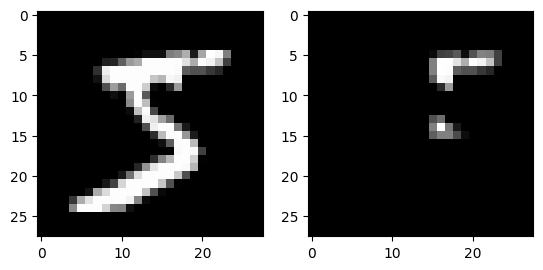

In [10]:
x = xs[0]
mask = SquareMask(10, x.shape)
# x = state_Ts.position[-1]
xi = jnp.array([10.0, 20.0])
y = measure(xi, x, mask)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(x, cmap="gray")
ax2.imshow(y, cmap="gray")
plt.show()

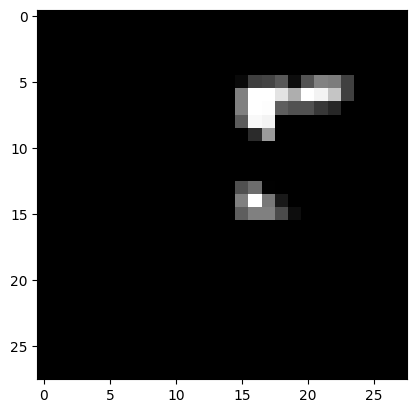

In [7]:
y = jax.vmap(measure, in_axes=(None, 0, None))(xi, xs[0:1], mask)
y.shape
plt.imshow(y[0], cmap="gray")

In [31]:
res = generate_cond_sample(y, xi, key, cond_sde, x.shape, 300, 200)


AttributeError: 'tuple' object has no attribute 'shape'

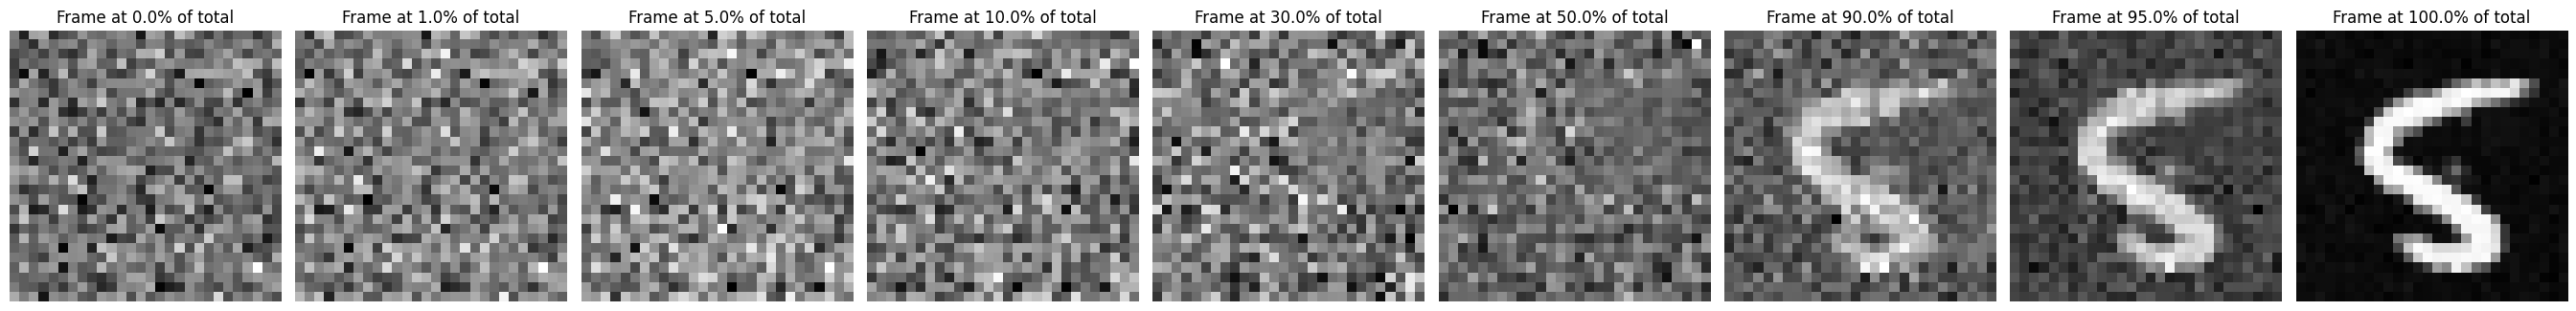

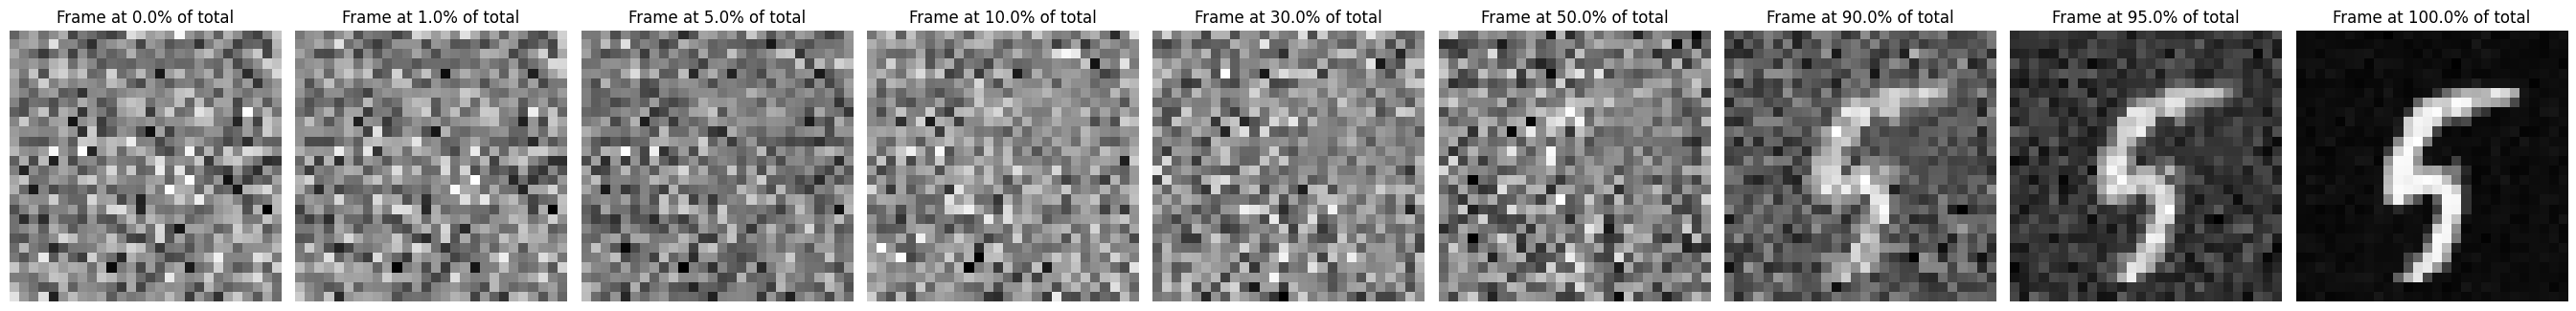

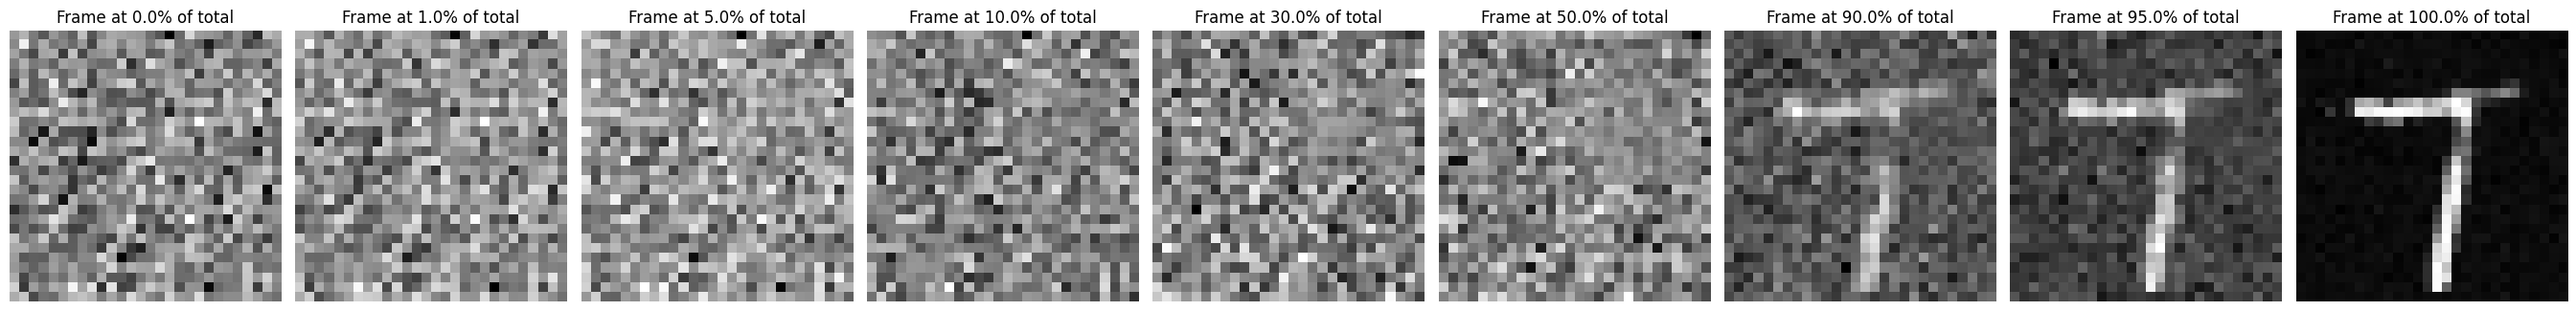

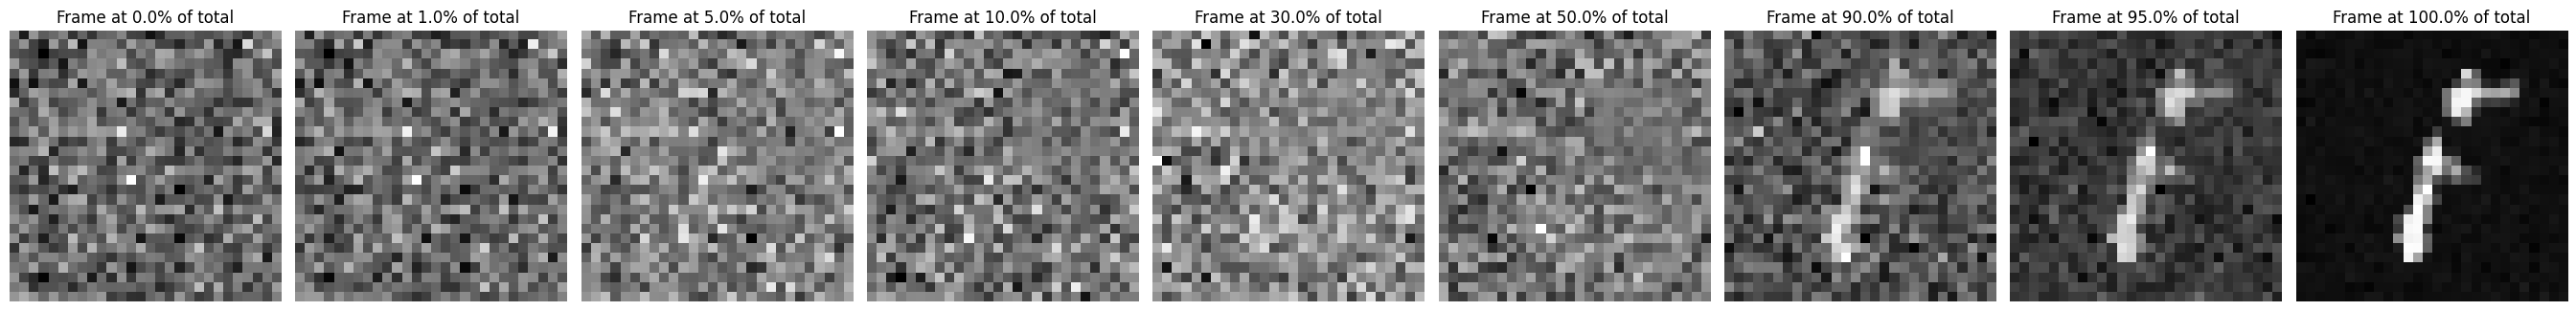

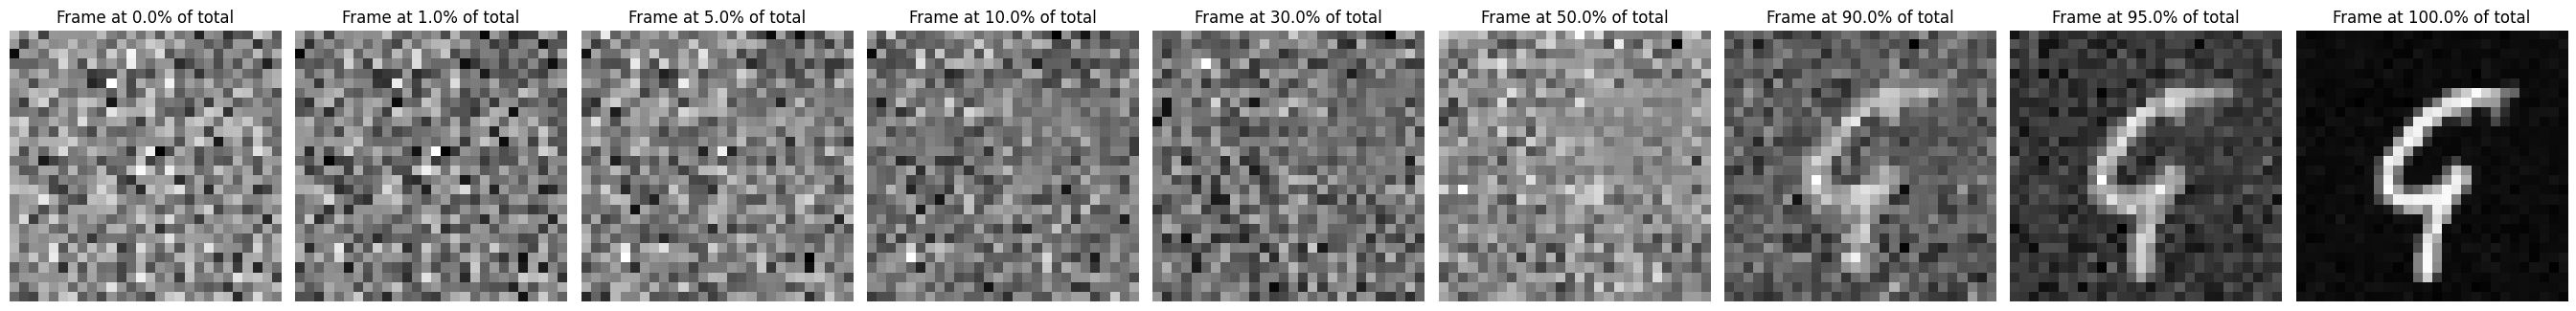

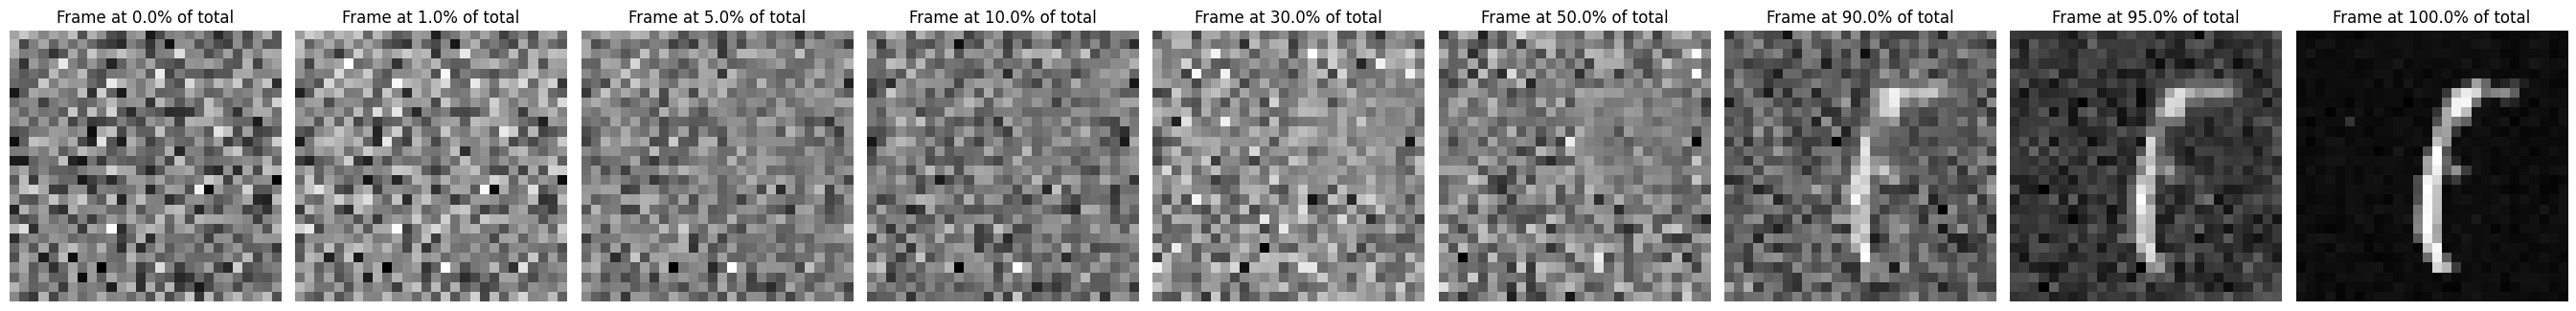

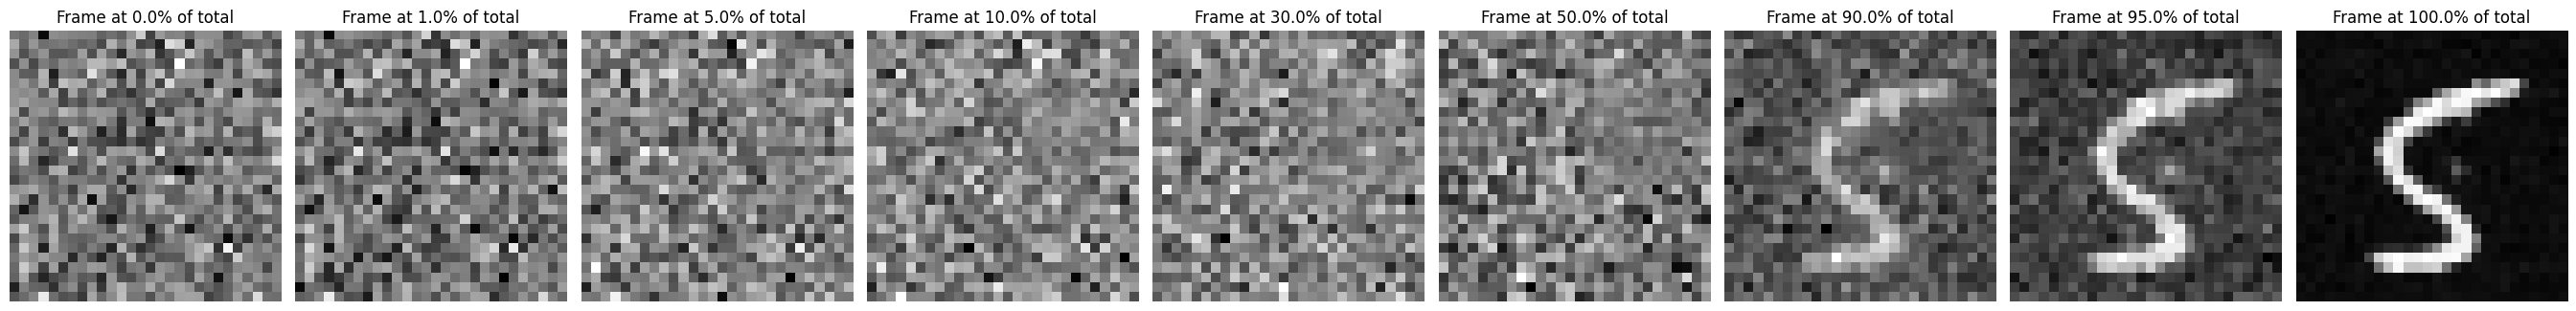

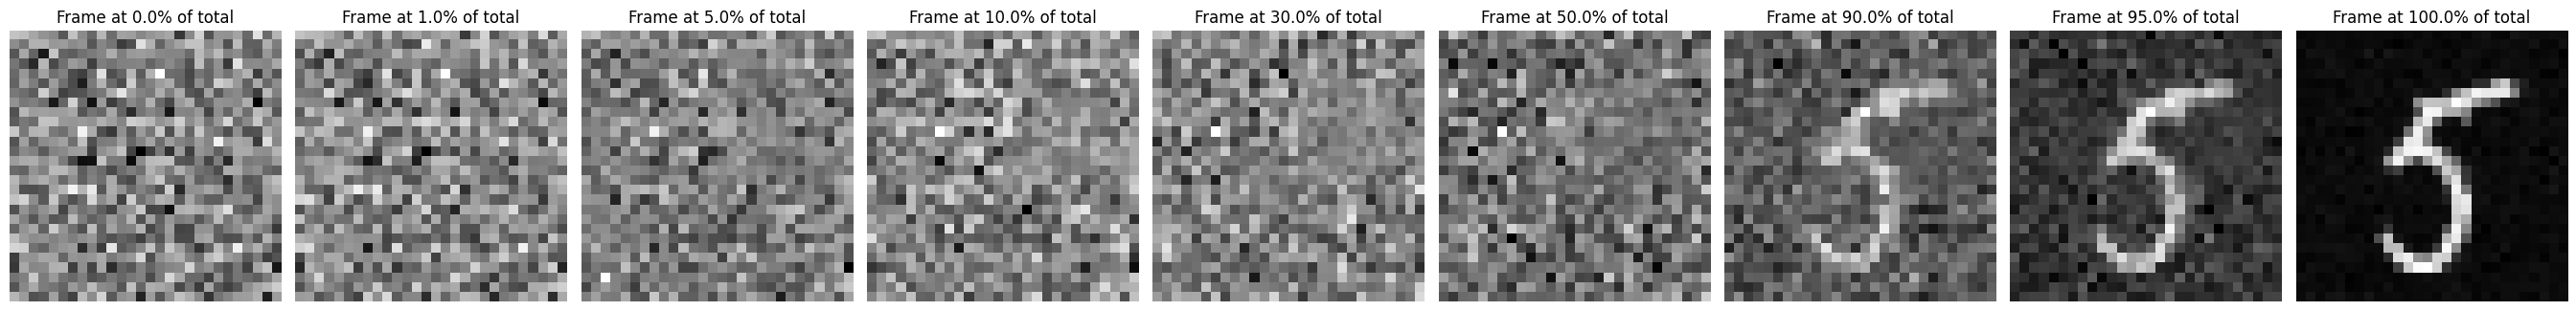

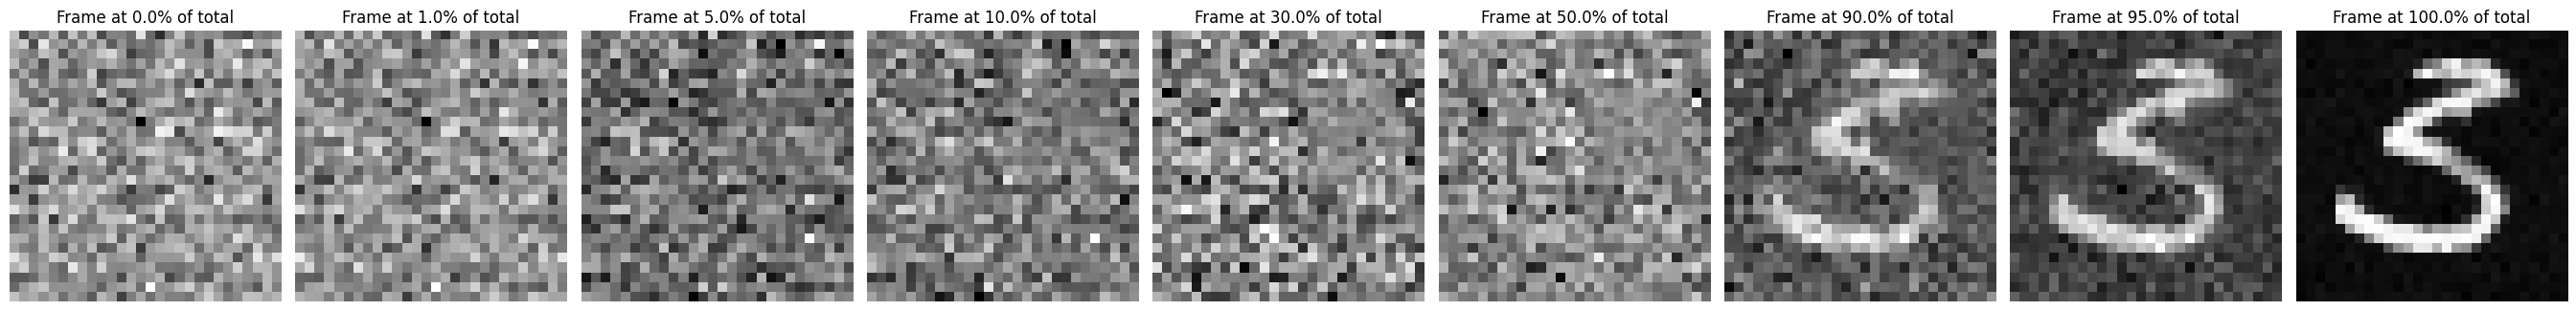

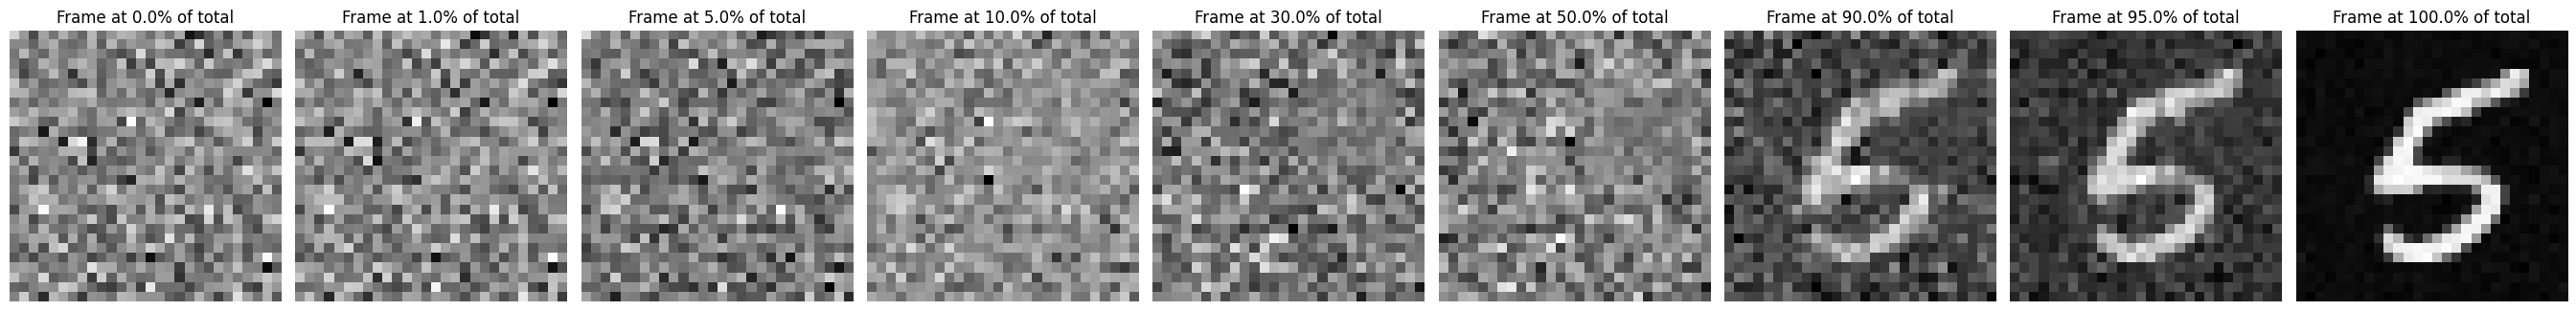

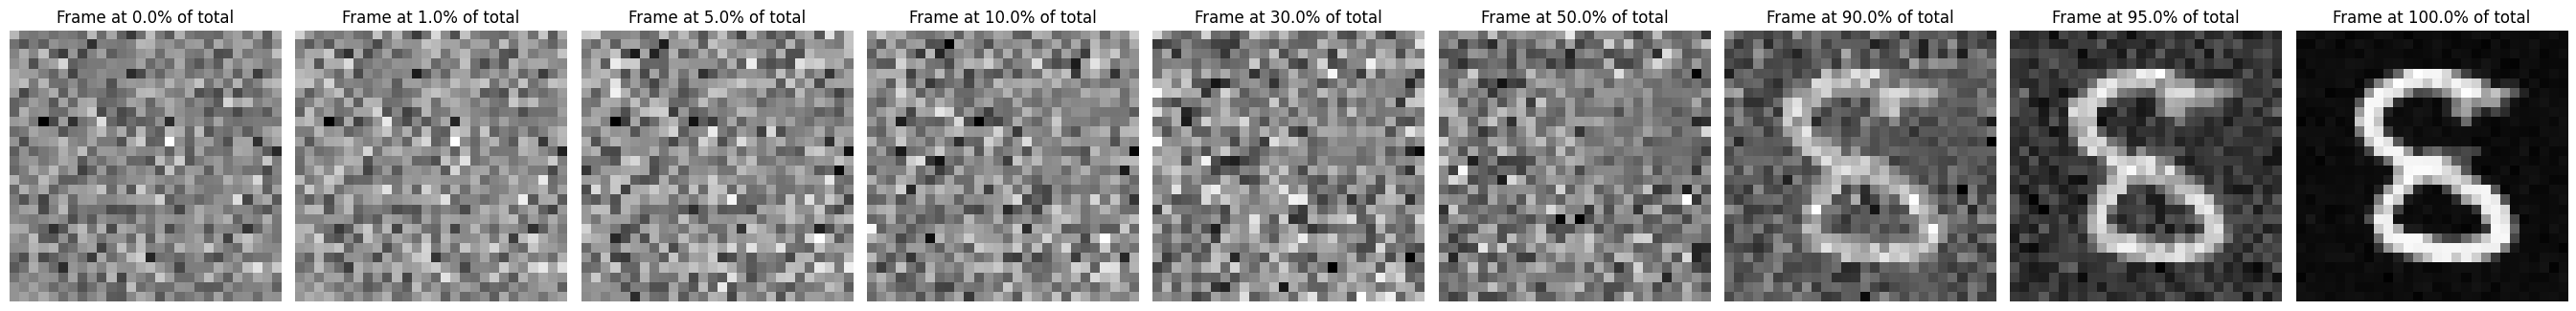

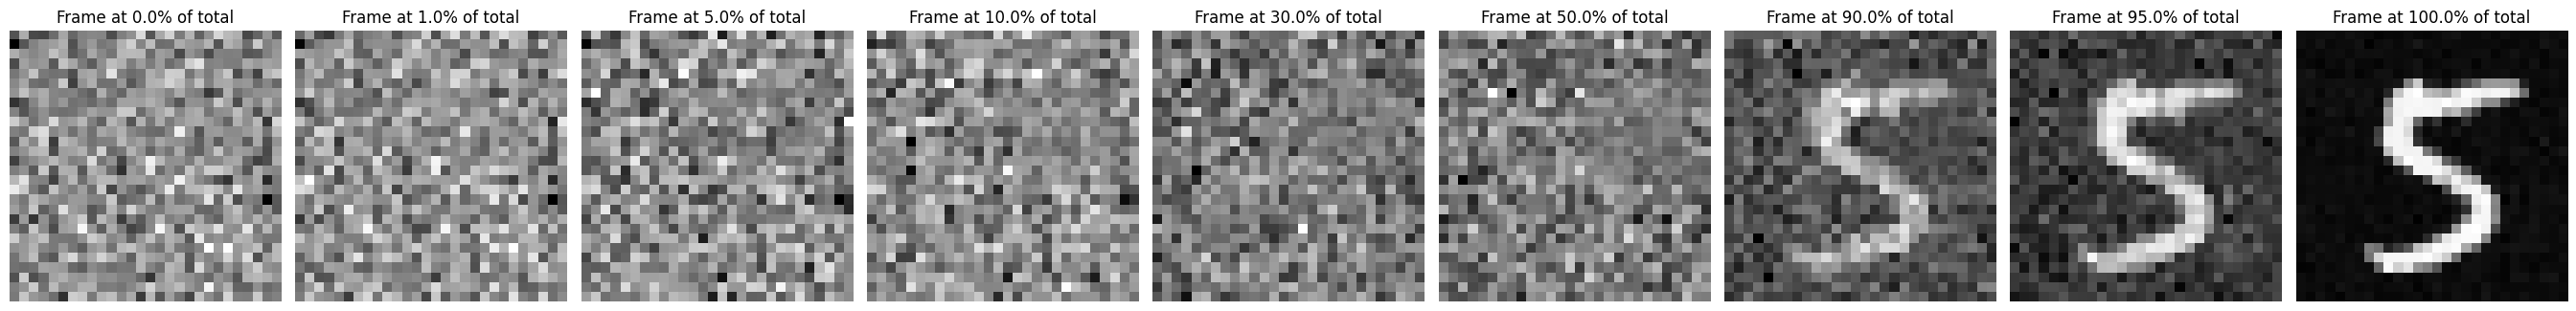

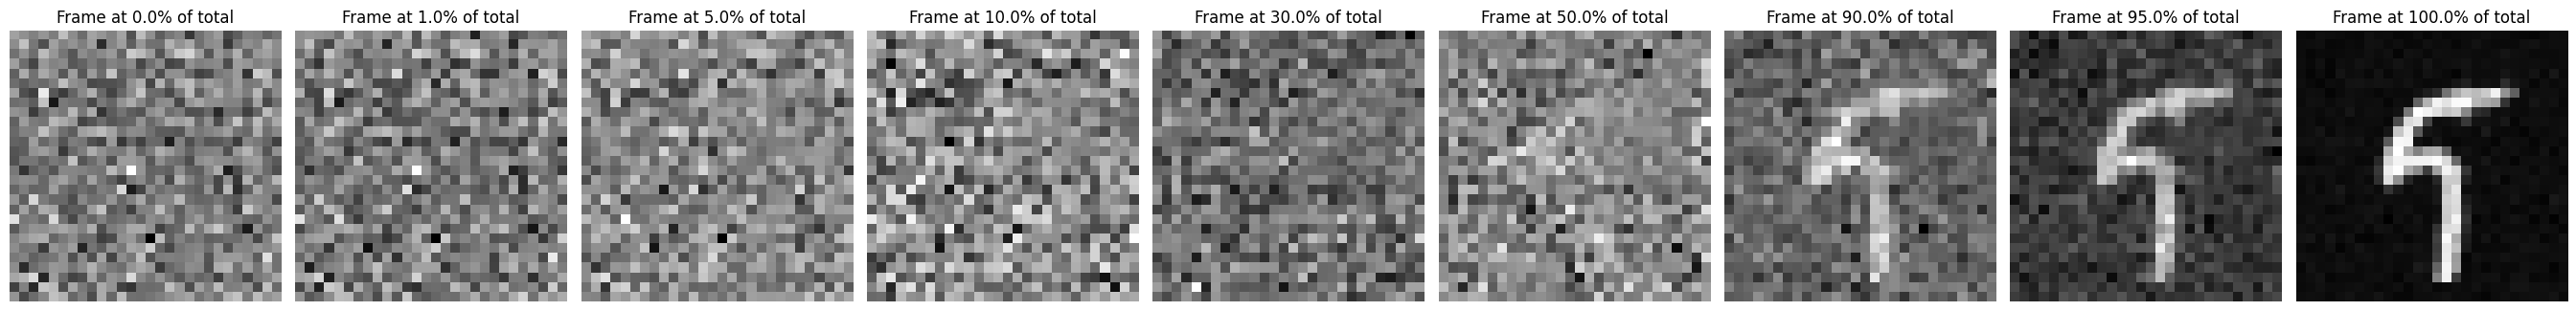

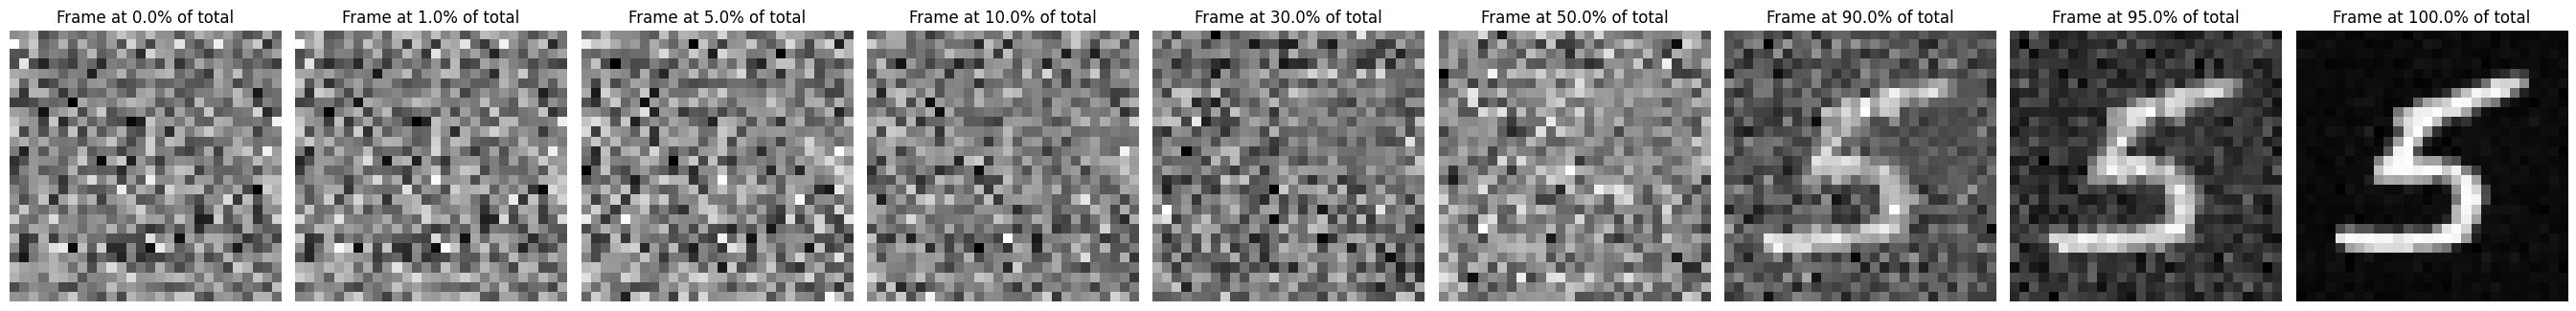

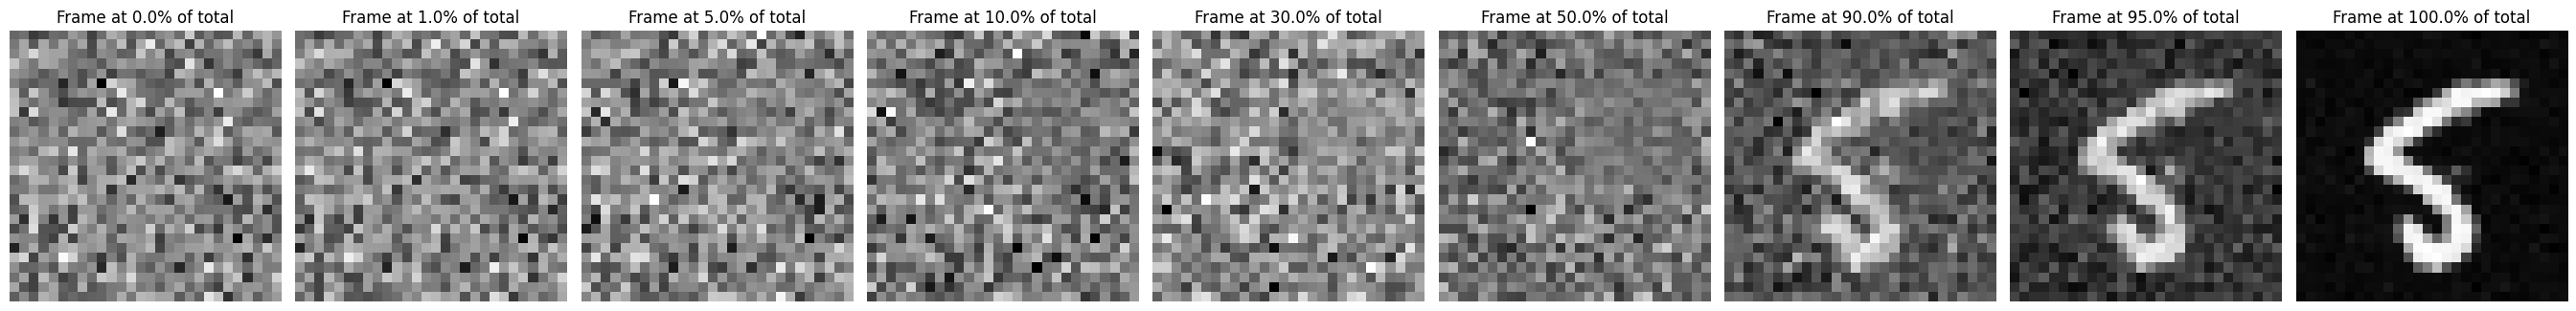

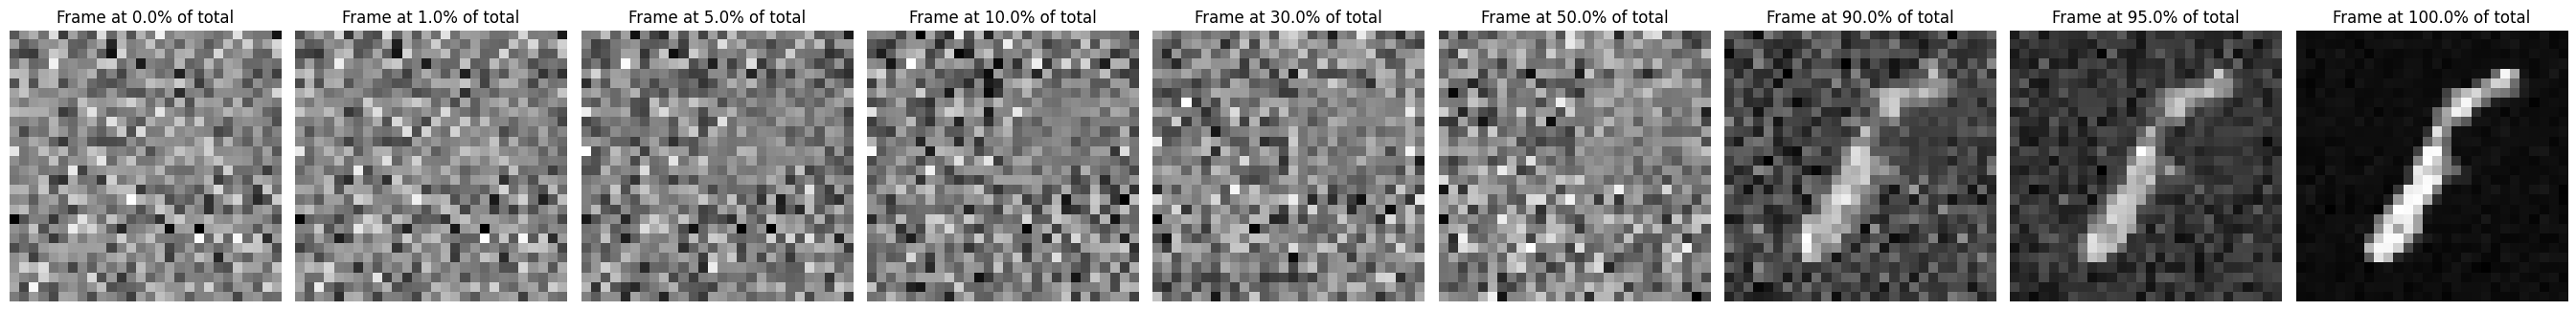

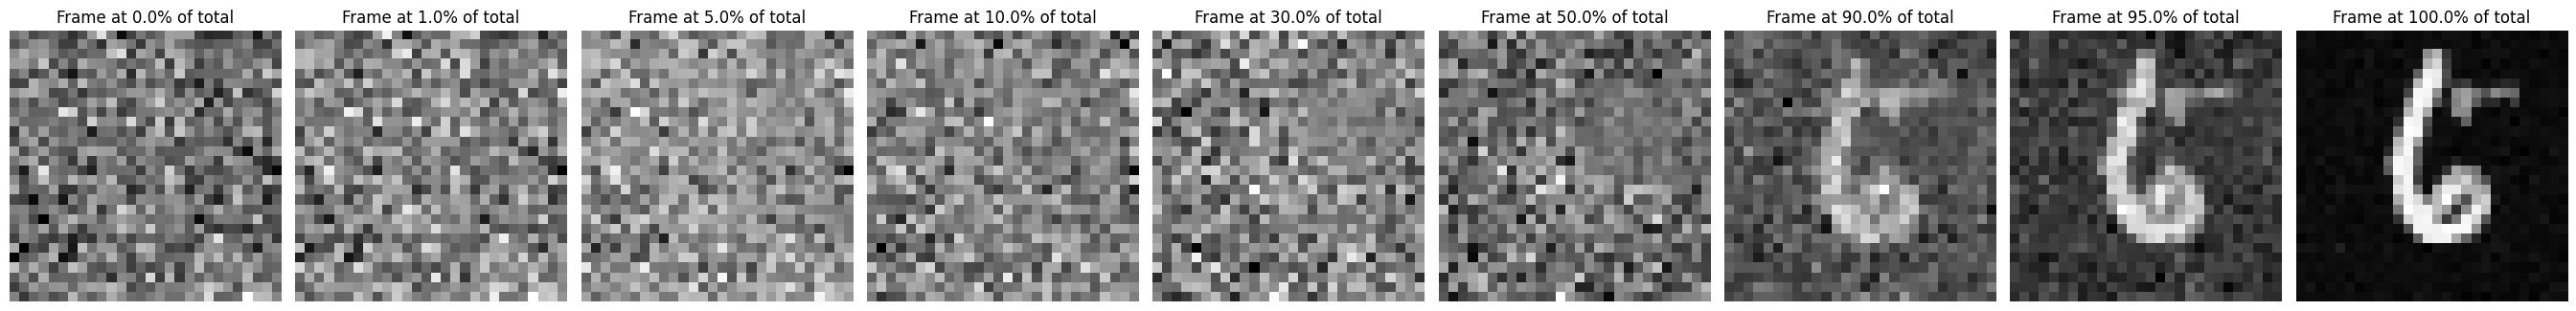

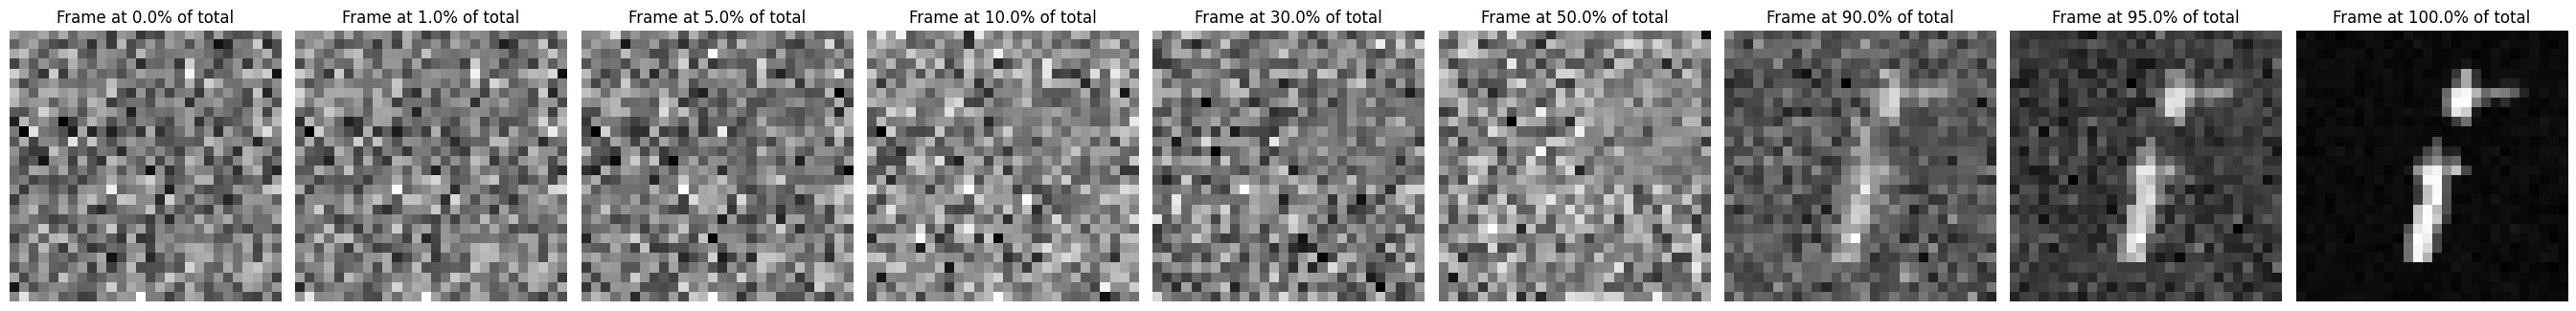

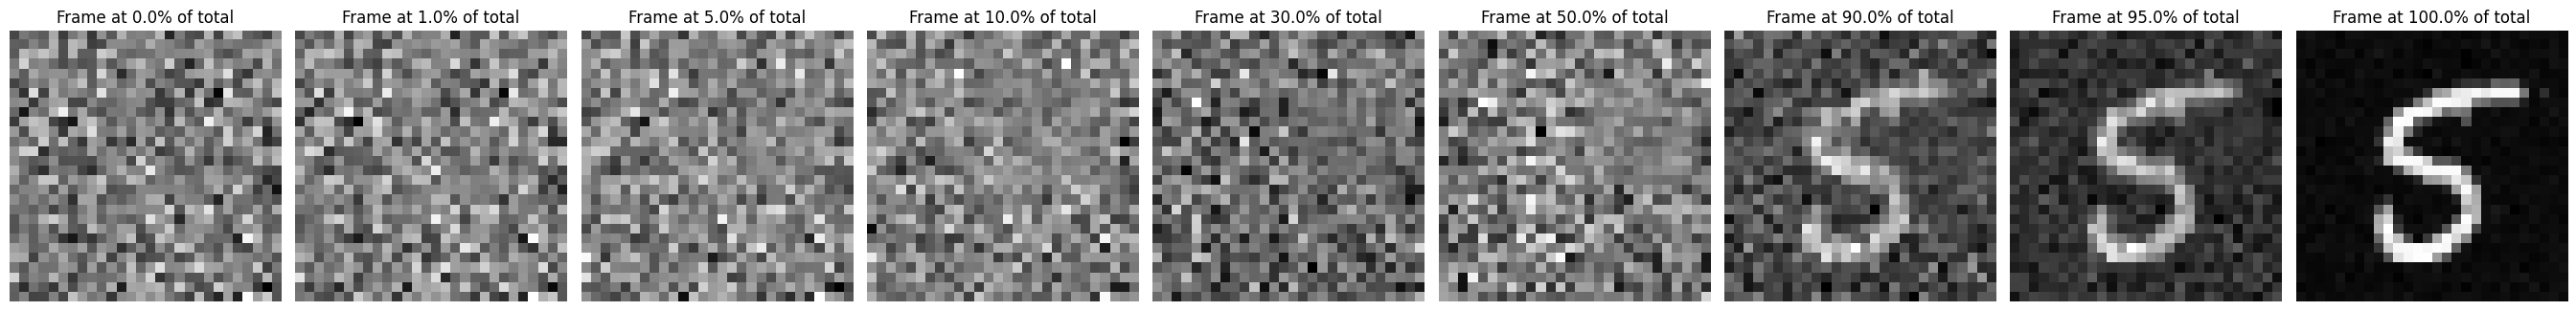

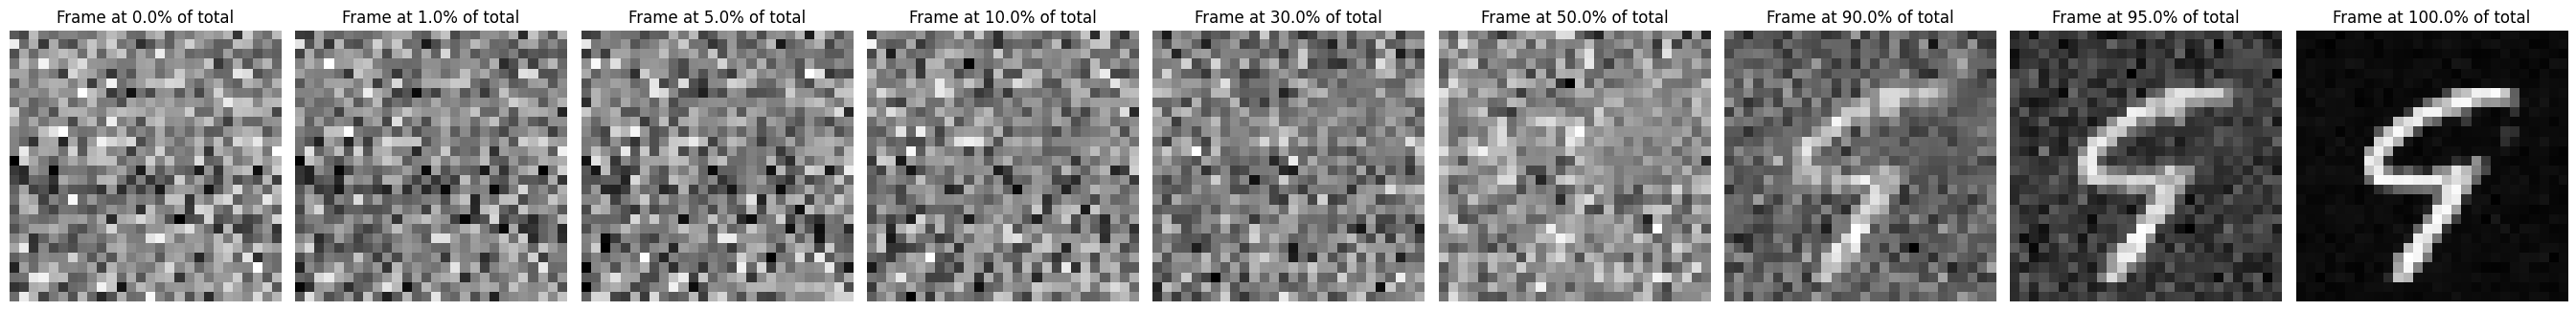

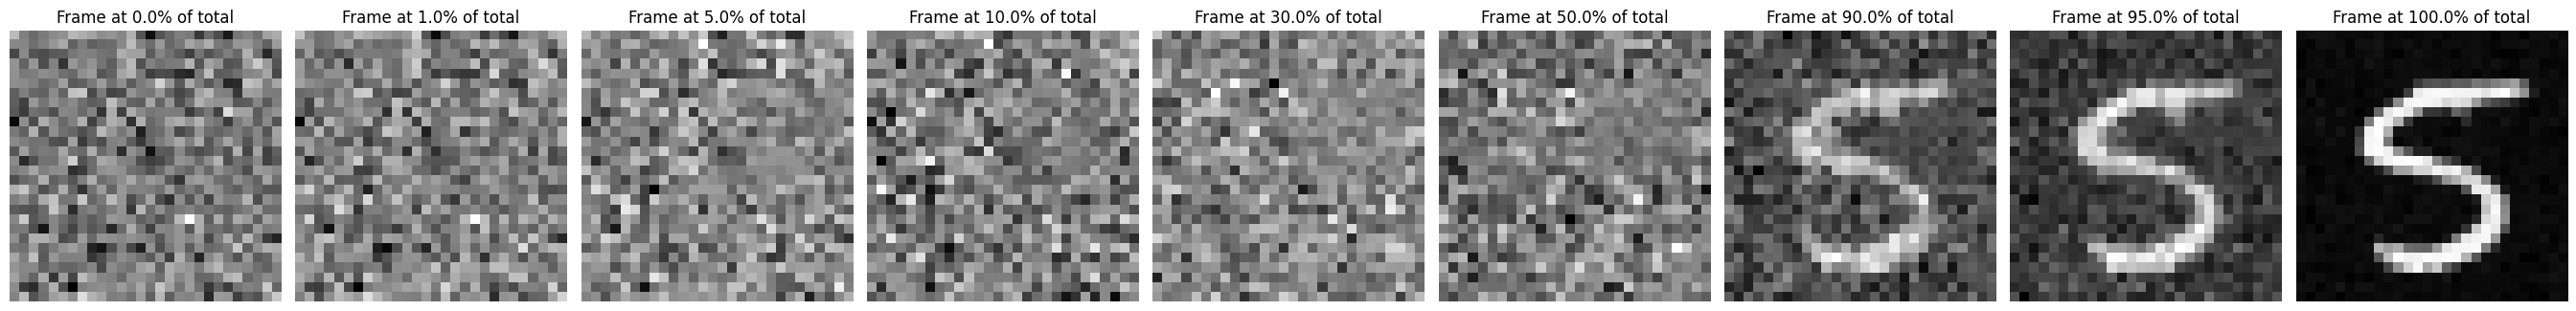

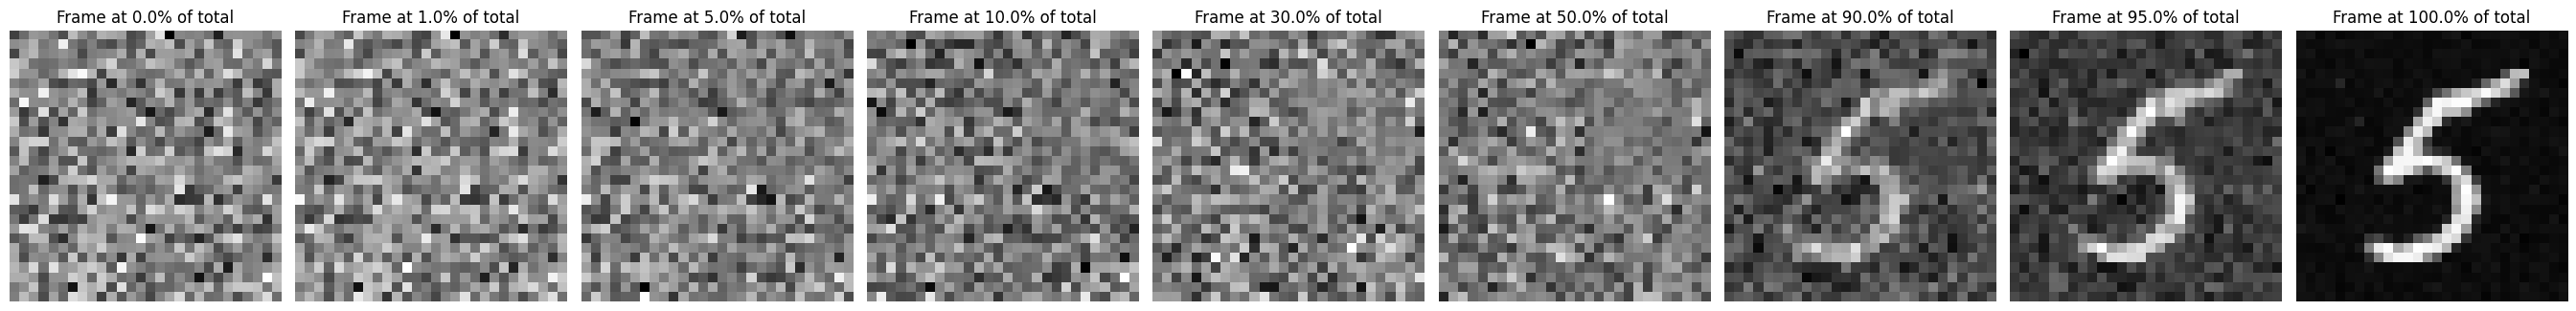

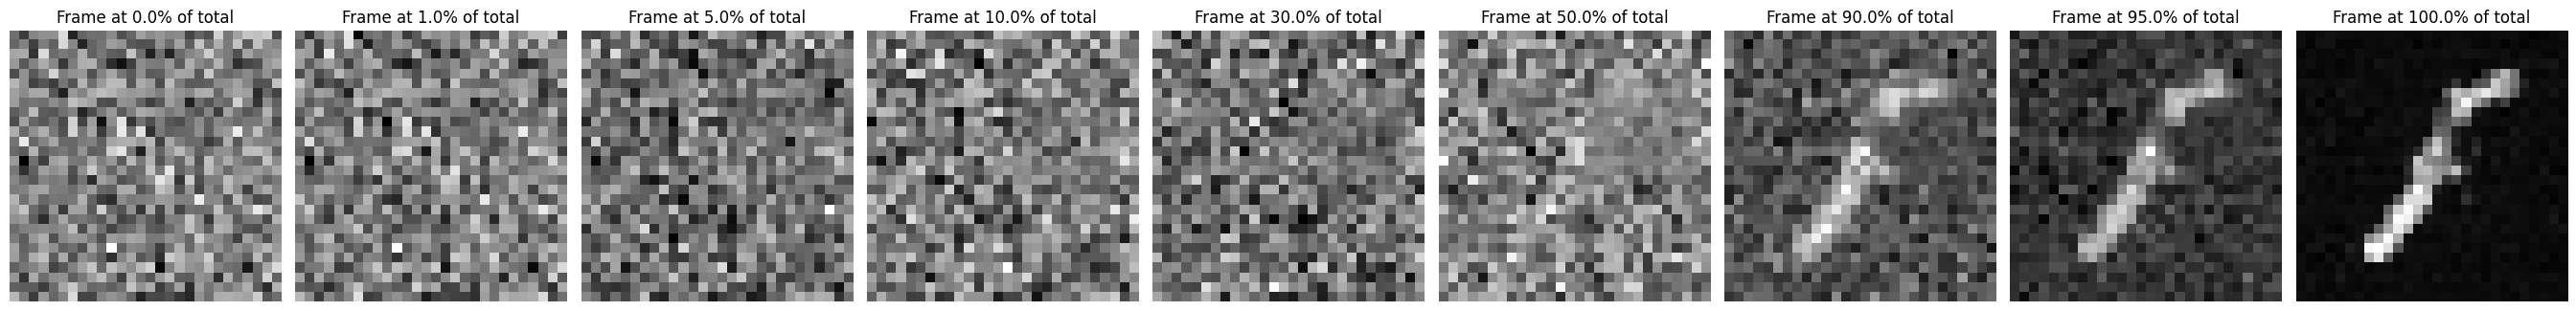

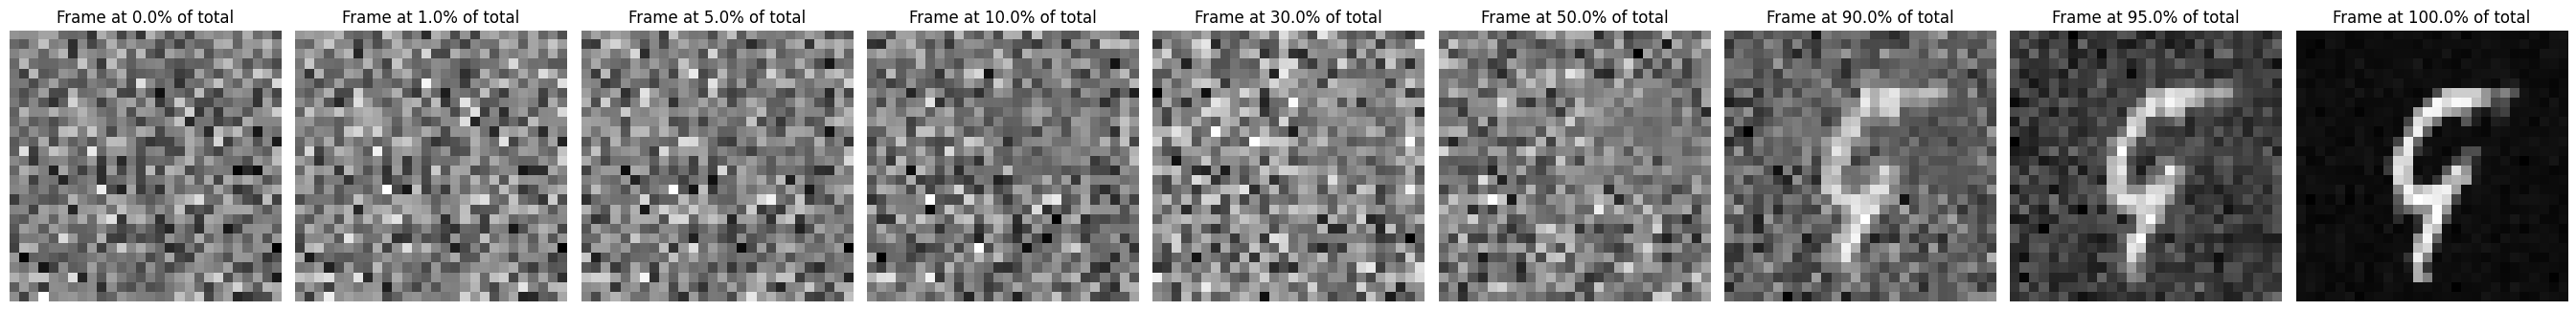

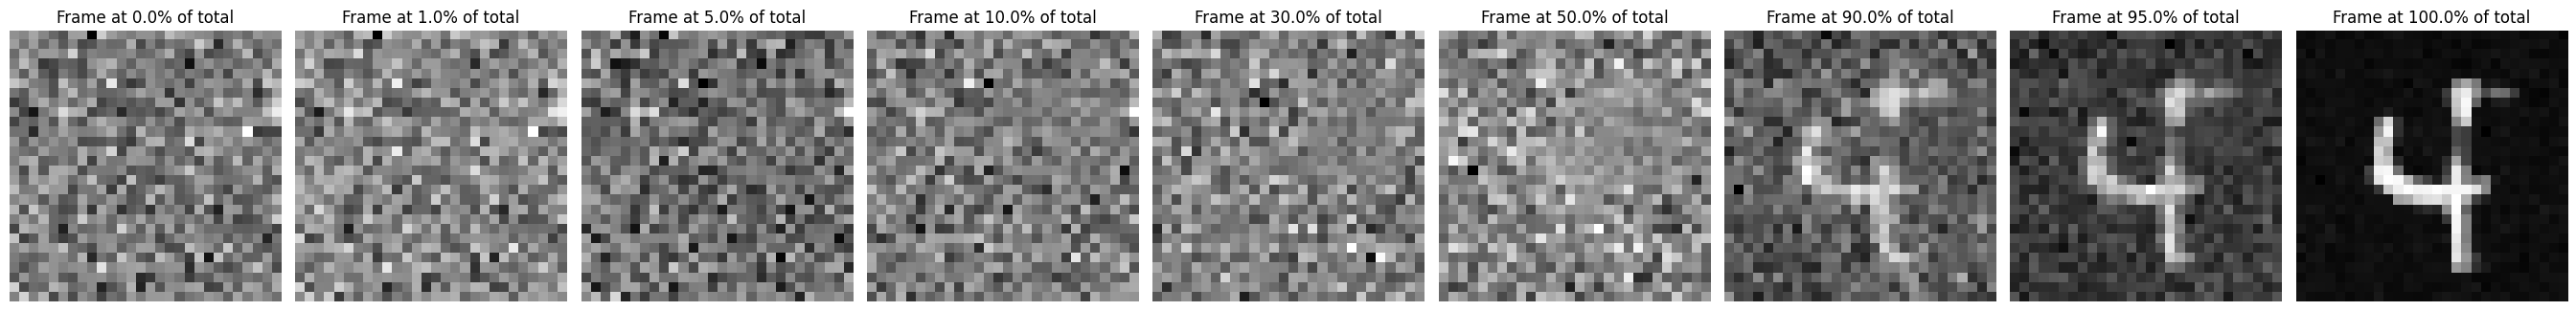

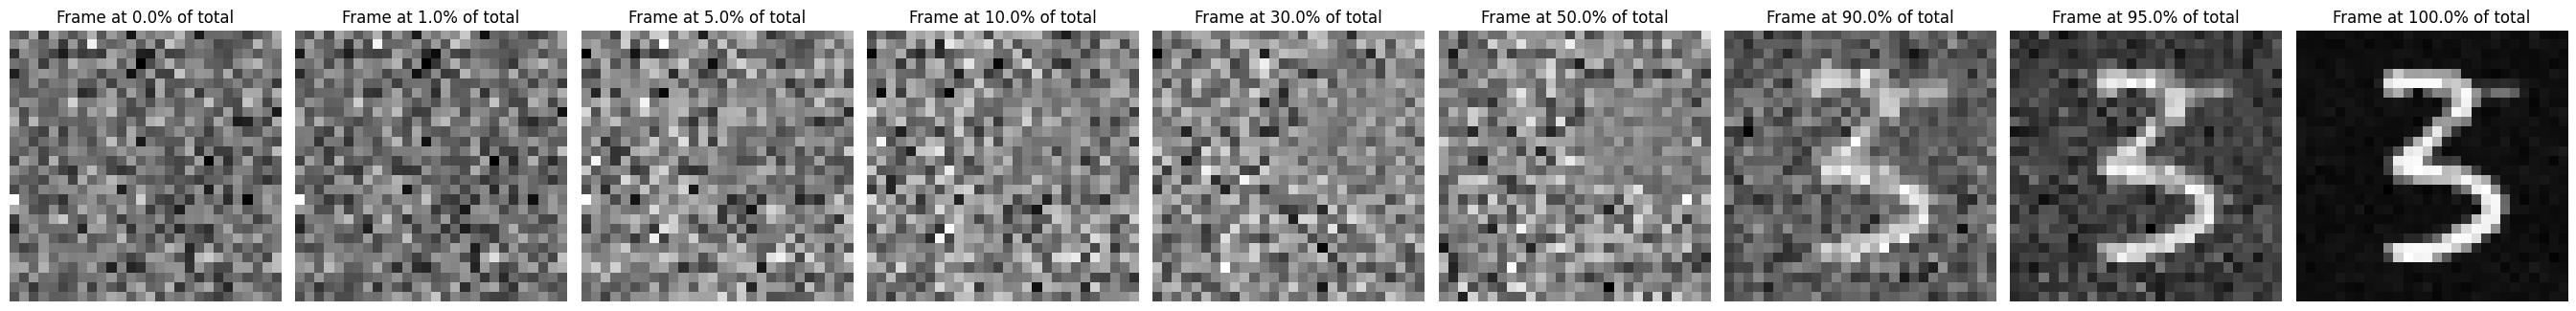

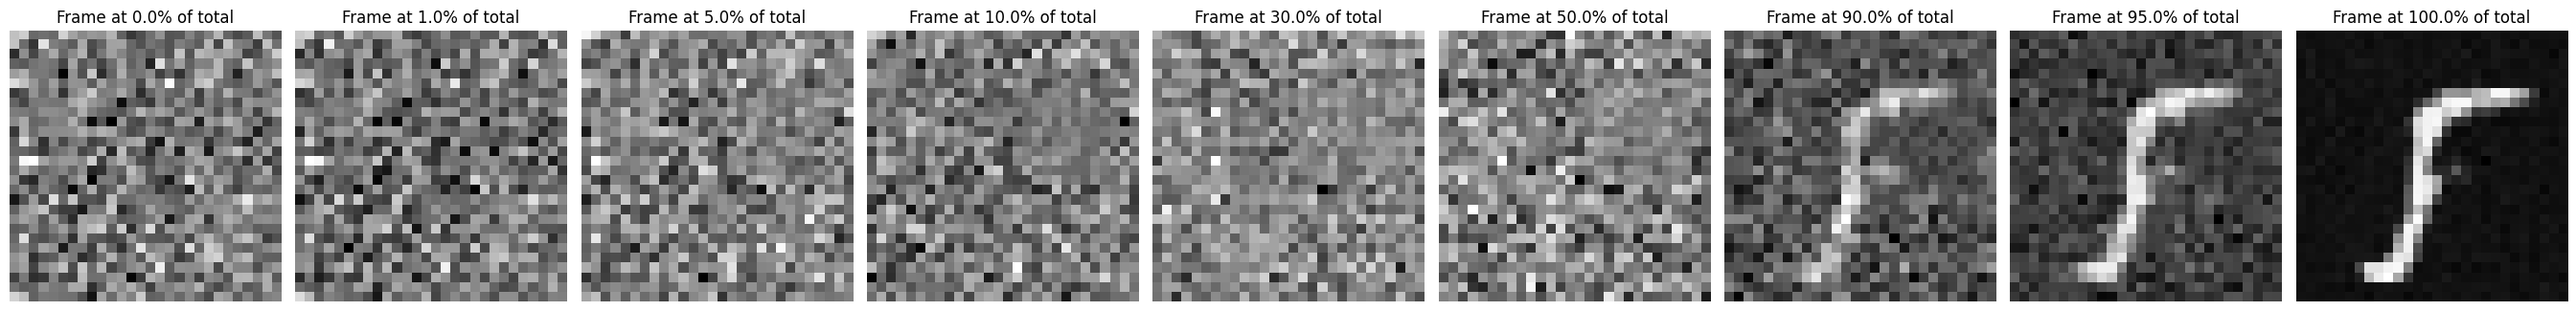

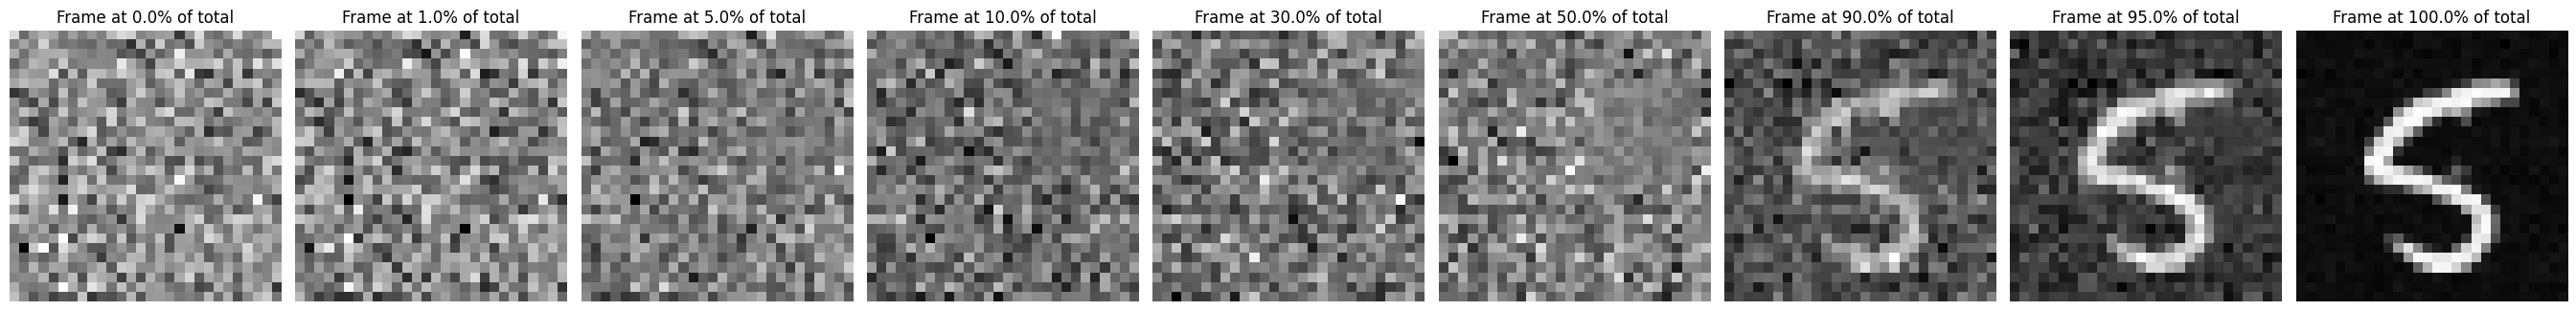

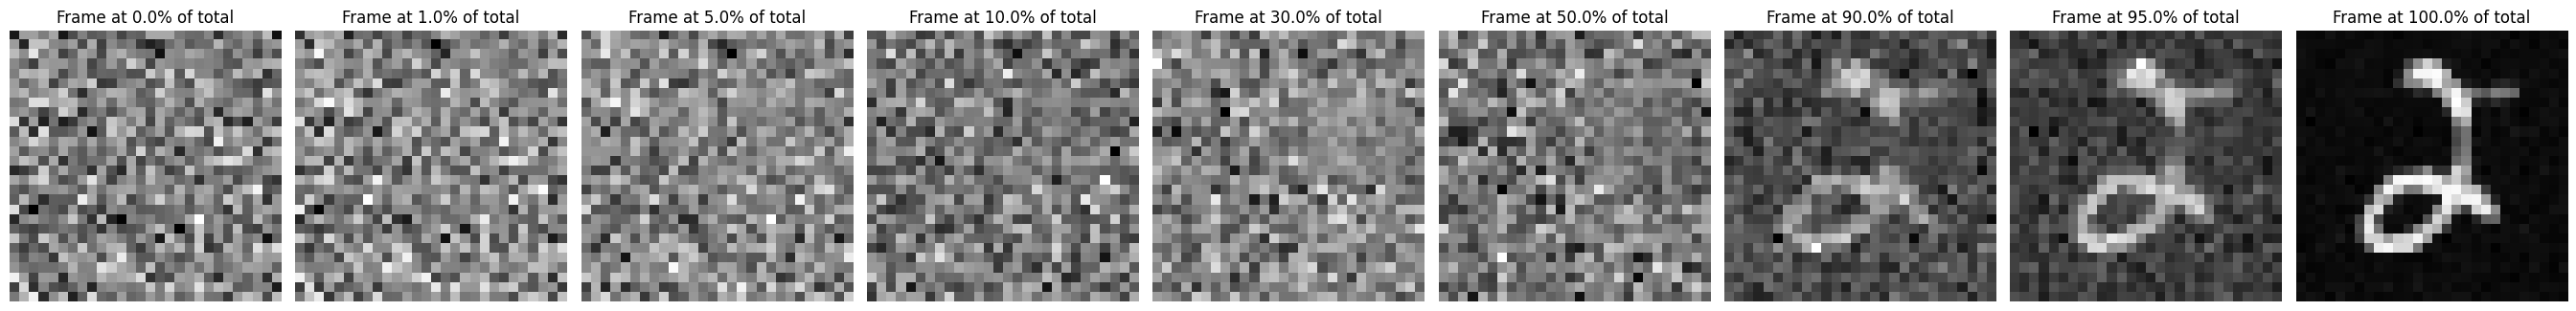

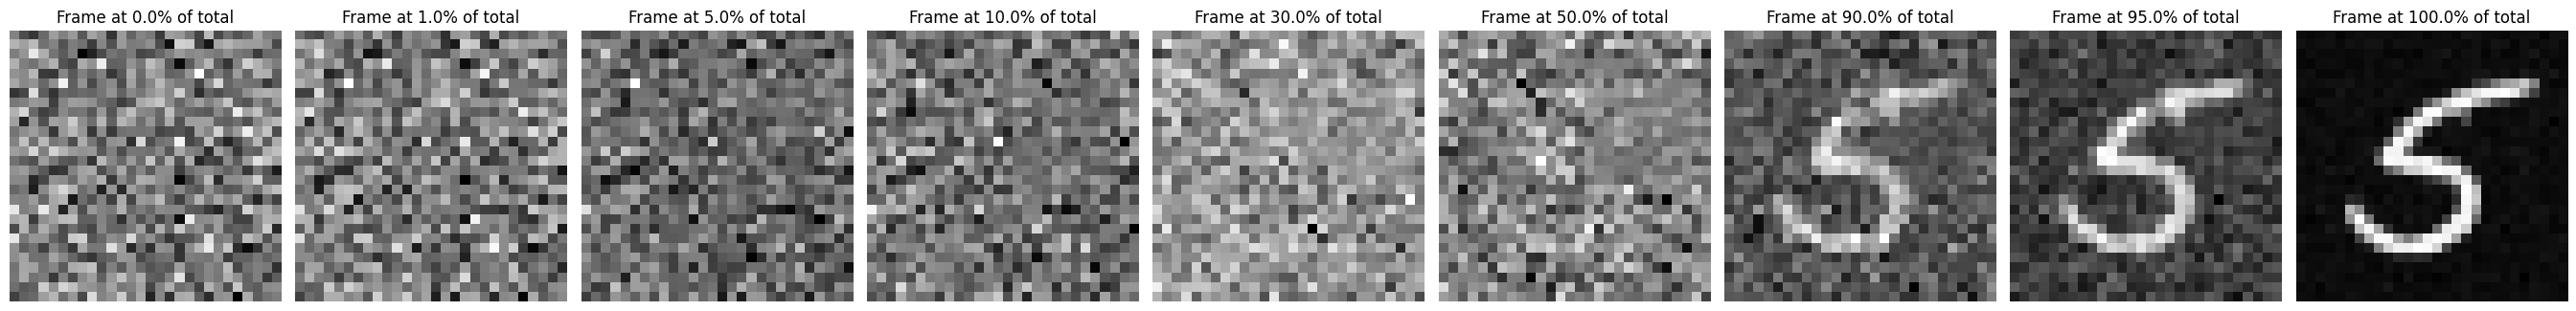

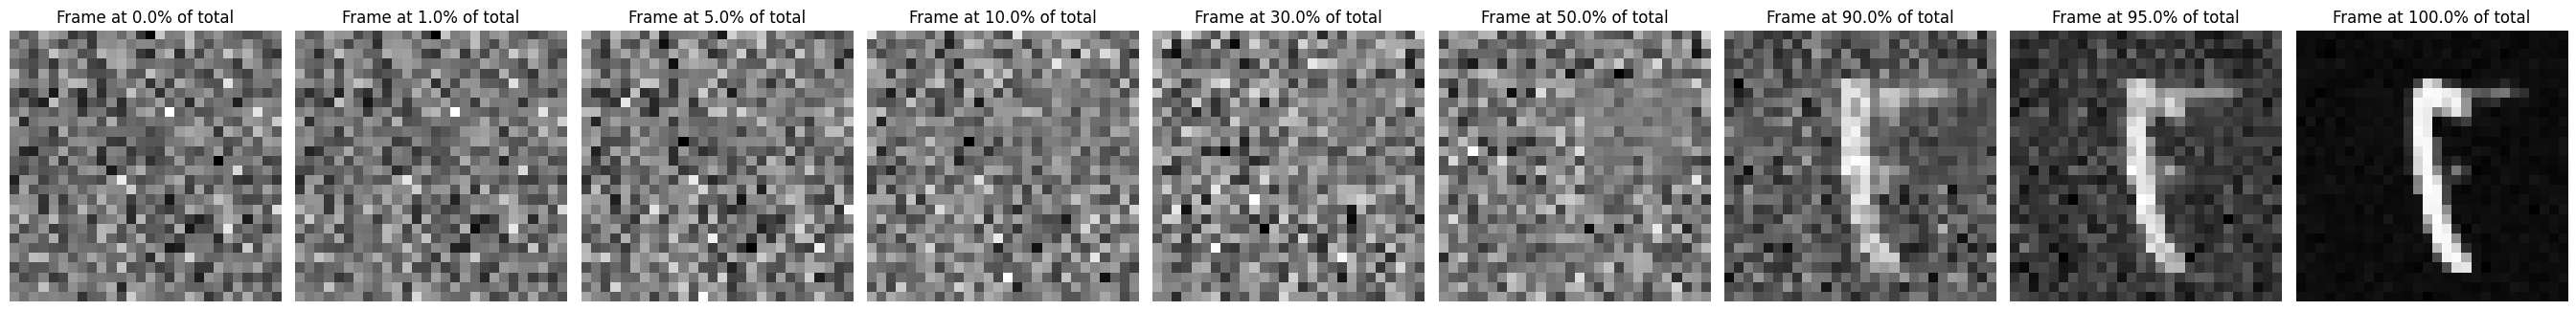

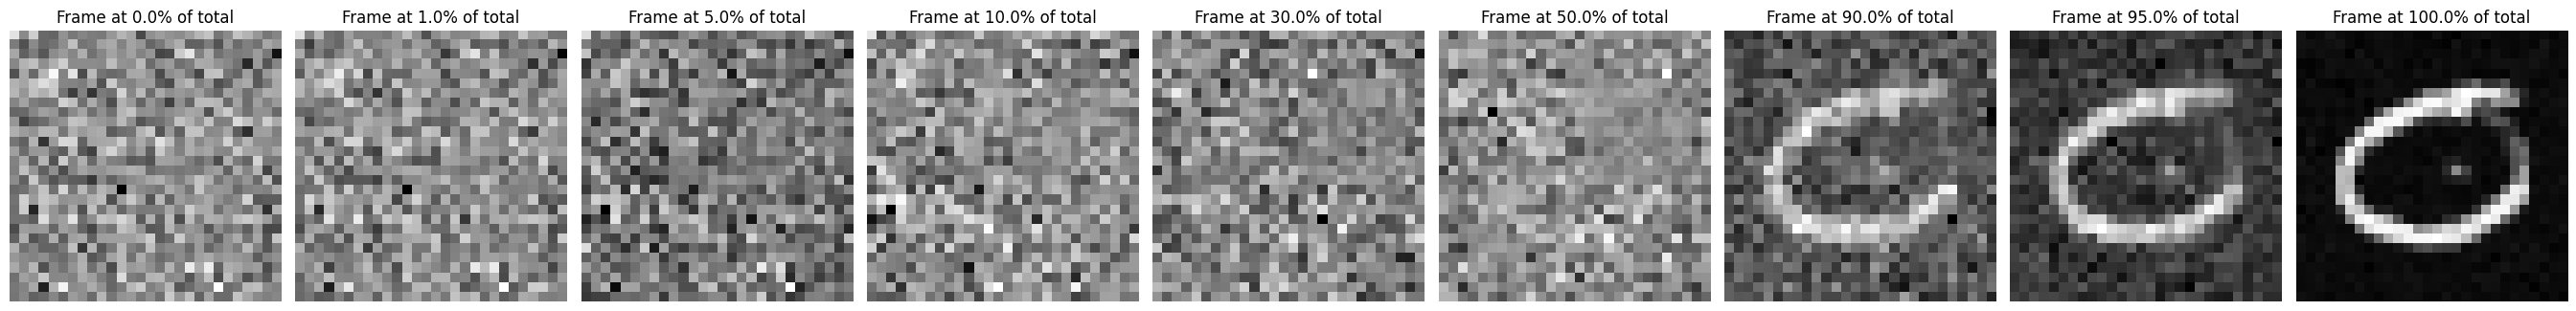

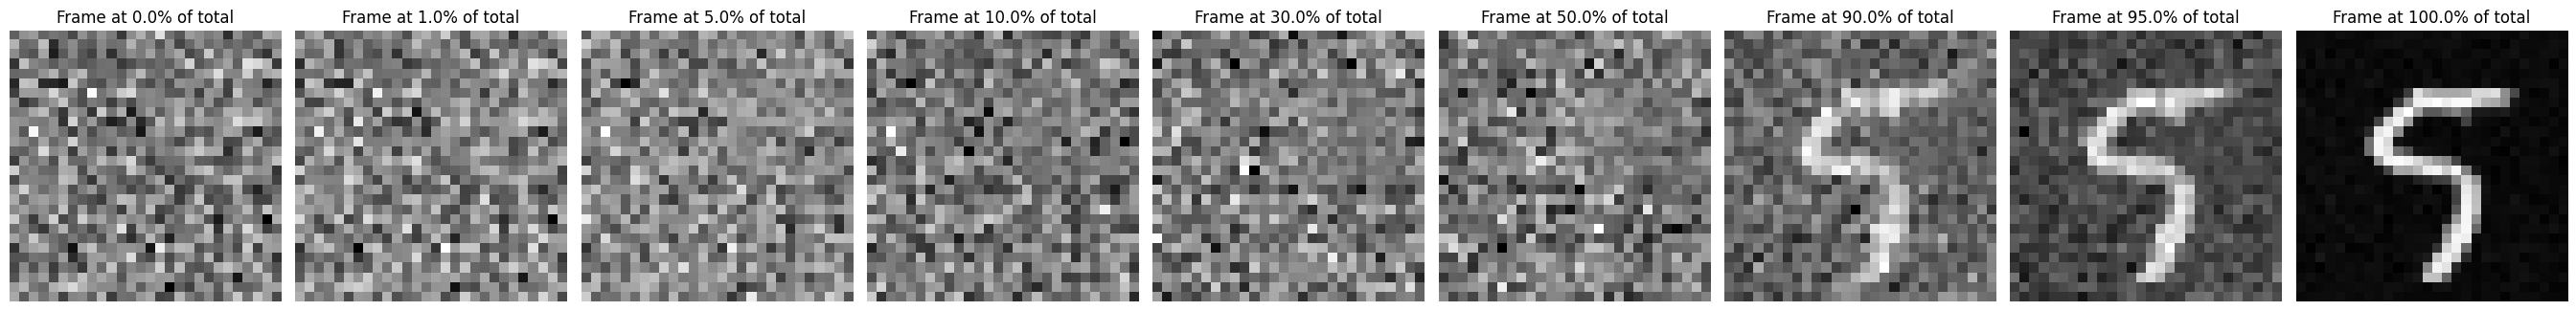

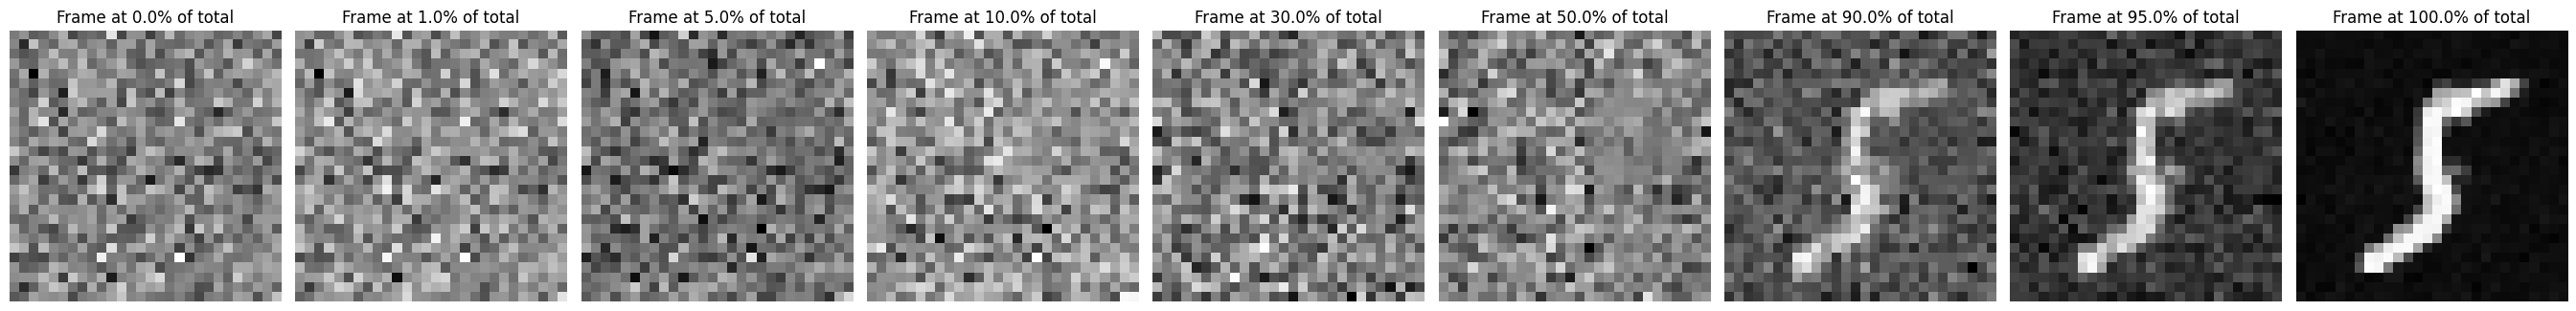

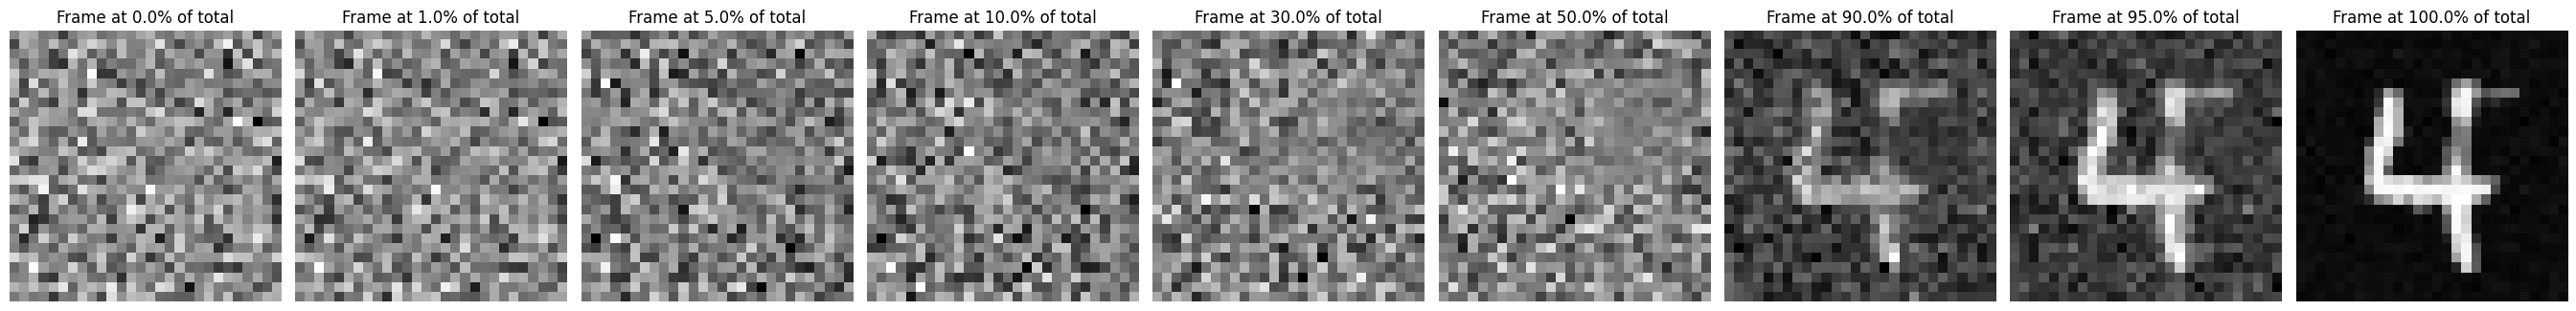

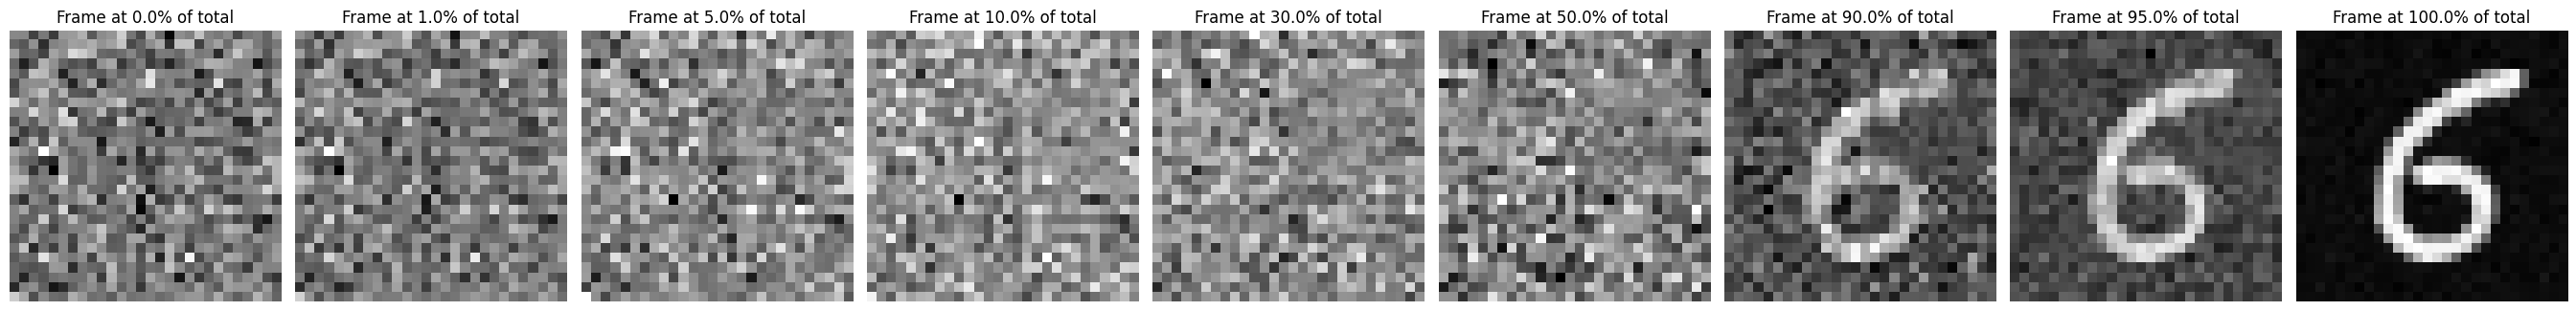

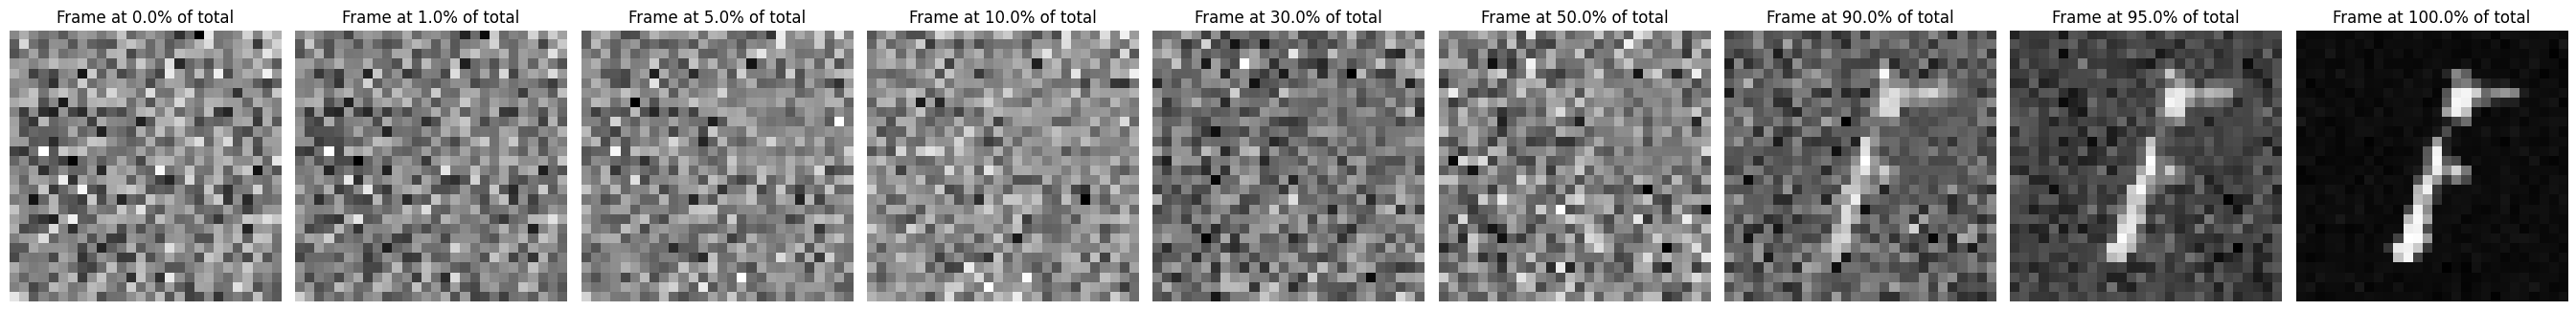

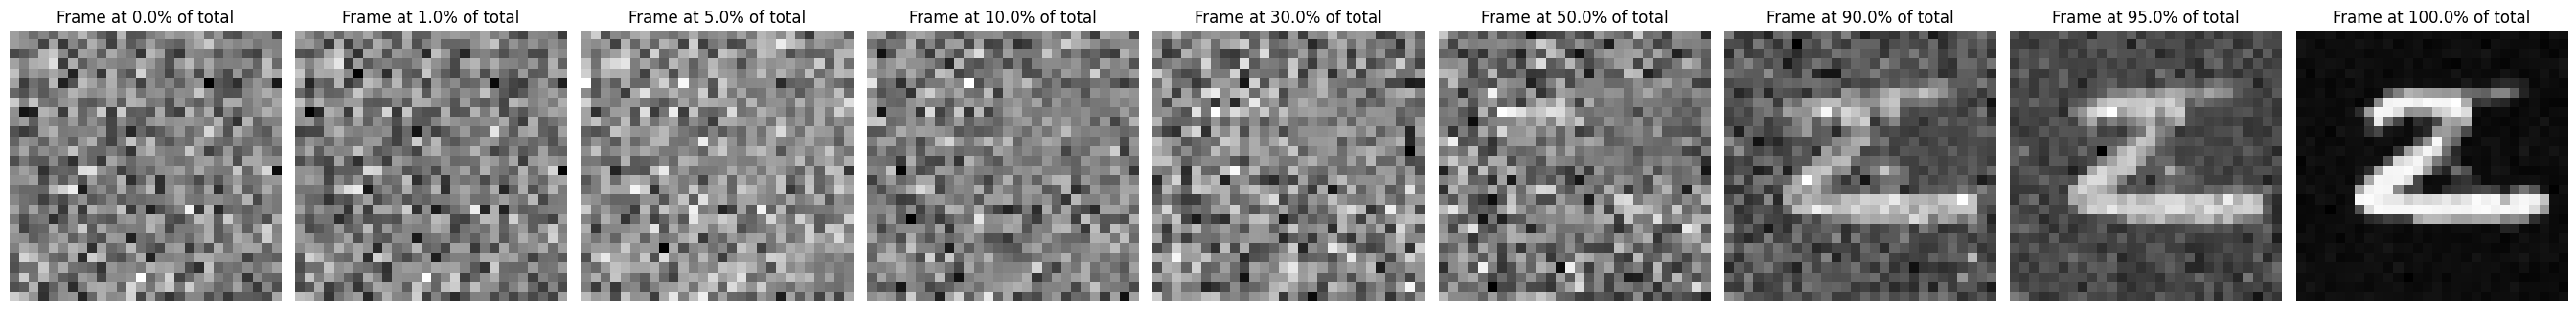

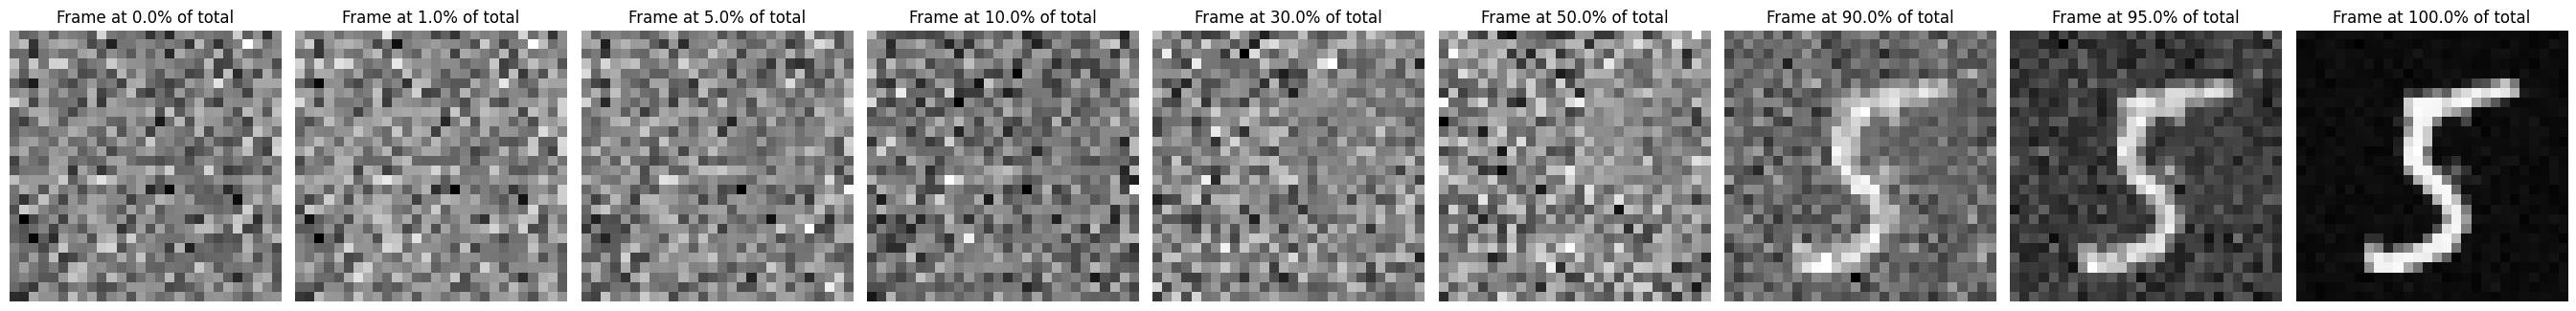

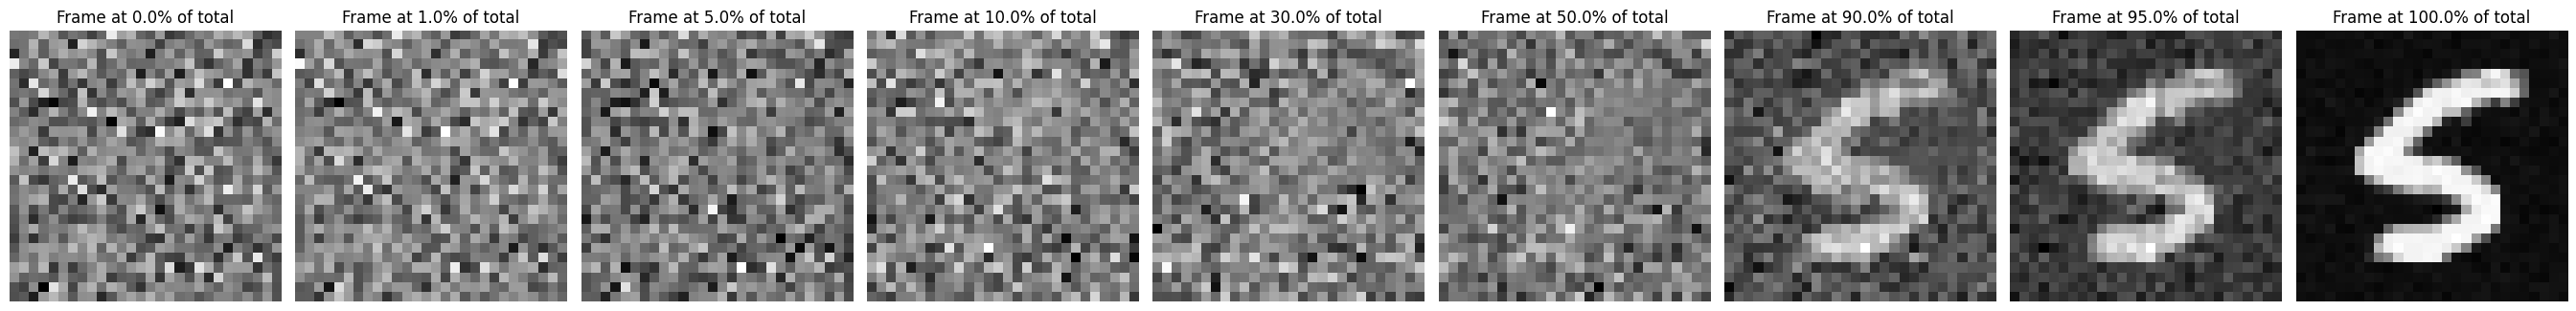

In [13]:
for i in range(40):
    plotter_line(res[1][0][:, i])

In [ ]:
np.exp(res[1][1][:])

In [ ]:
i = 32
plotter_line(res[1][0][:, i])

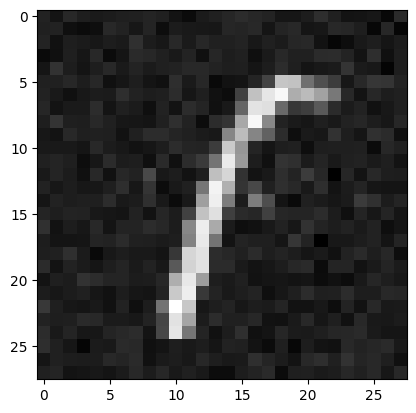

In [16]:
i = 49
plt.imshow(res[0][0][i], cmap="gray")

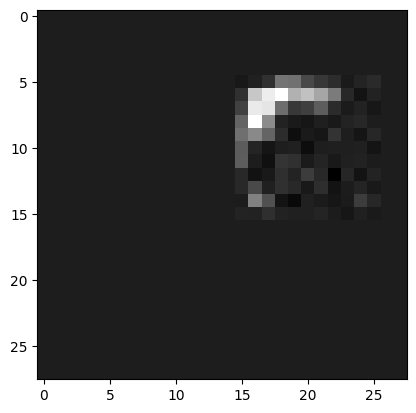

In [17]:
plt.imshow(measure(xi, res[0][0][i], mask), cmap="gray")

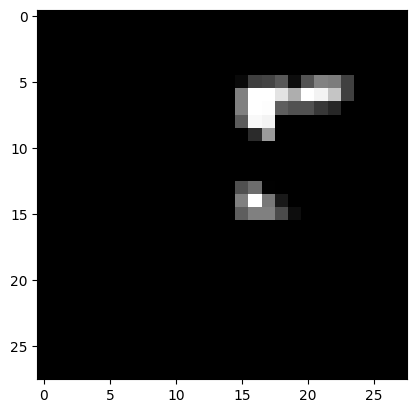

In [18]:
plt.imshow(y, cmap="gray")

# Test impl opt

In [14]:
# Import necessary modules
from diffuse.optimizer import ImplicitState, impl_step
import optax

NameError: name 'design' is not defined

In [36]:
#past_y = measure(xi, x, mask)
xis = jnp.array([[10.0, 20.0],
                 [-1.0, 2.0], 
                 [3.8, 8.]])
y = jax.vmap(measure, in_axes=(0, None, None))(xis, xs[0], mask).mean(axis=0)

n_t = 299
ts = jnp.linspace(0, tf, n_t)

key_noise = jax.random.split(key, n_t)
state_0 = SDEState(y, jnp.zeros_like(y))
past_y = jax.vmap(sde.path, in_axes=(0, None, 0))(key_noise, state_0, ts)



#res = generate_cond_sample(y, xi, key, 500, cond_sde, x.shape)
#res = generate_cond_sample(y, xi, key, cond_sde, x.shape)
# thetas (n_t, n_particles)
# thetas = res[1][0]
# random generate the thetas
n_particles = 100
n_contrast = 100
#thetas = jax.random.normal(key, (n_t, n_particles, *x.shape))
#cntrst_thetas = jax.random.normal(key, (n_t, n_contrast, *x.shape))
thetas = res[1][0][:, :n_particles]
cntrst_thetas = res[1][0][:, n_particles:n_particles+n_contrast]
print(f'{thetas.shape}, {cntrst_thetas.shape}')


design = jnp.zeros_like(xi) + 26.

# Initialize optimizer
learning_rate = 1e-2
optimizer = optax.chain(optax.adam(learning_rate), optax.scale(-1))
opt_state = optimizer.init(design)
step = jax.jit(partial(impl_step, cond_sde=cond_sde, optx_opt=optimizer, ts=ts, dt=dt))

# Create initial state
initial_state = ImplicitState(thetas, cntrst_thetas, design, opt_state)

# Set up parameters for impl_step
key_step = jax.random.PRNGKey(42)
ts = jnp.linspace(0, tf, n_t)
dt = tf / (n_t - 1)

# Run impl_step
new_state = step(initial_state, key_step, past_y)

(299, 100, 28, 28, 1), (299, 100, 28, 28, 1)


In [34]:
print(res[1][0].shape)

(299, 200, 28, 28, 1)


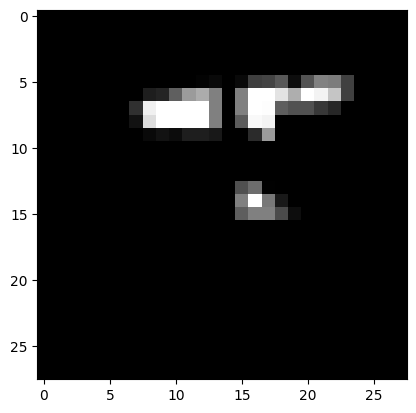

In [22]:
plt.imshow(y, cmap="gray")

# Le truc lent à ralentir^-1

In [37]:
opt_steps = 5_000
keys_opt = jax.random.split(key_step, opt_steps)
def step(new_state, key):
    new_state = impl_step(new_state, key, past_y, cond_sde=cond_sde, optx_opt=optimizer, ts=ts, dt=dt)
    return new_state, new_state.xi

new_state, hist_xi = jax.lax.scan(step, initial_state, keys_opt)

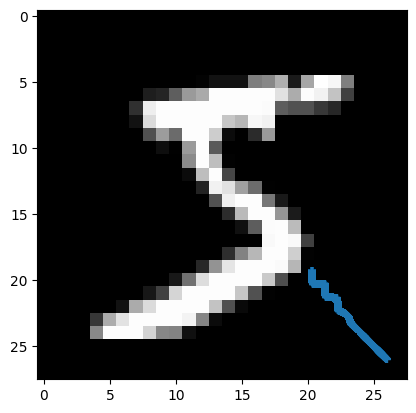

In [38]:
plt.scatter(hist_xi[:, 0], hist_xi[:, 1], marker='+')
plt.imshow(xs[0], cmap="gray")

In [35]:
for i in tqdm(range(10000)):
    new_state = step(new_state, key_step, past_y)


100%|██████████| 10000/10000 [00:00<00:00, 10374.63it/s]


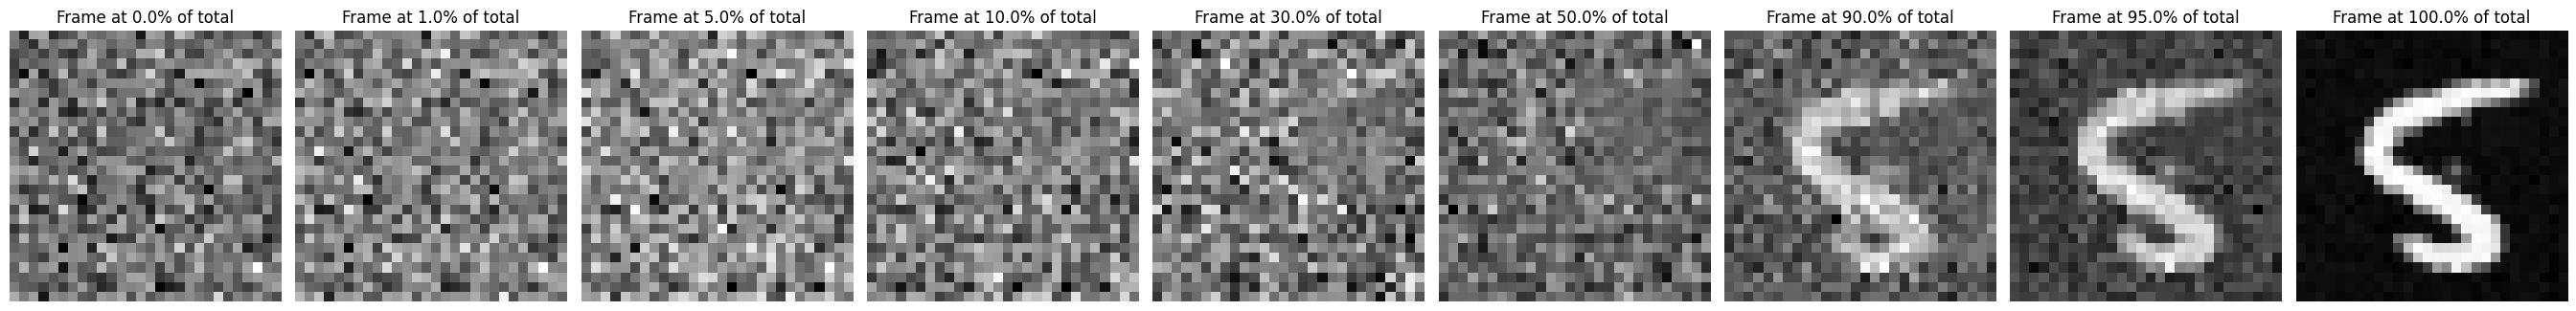

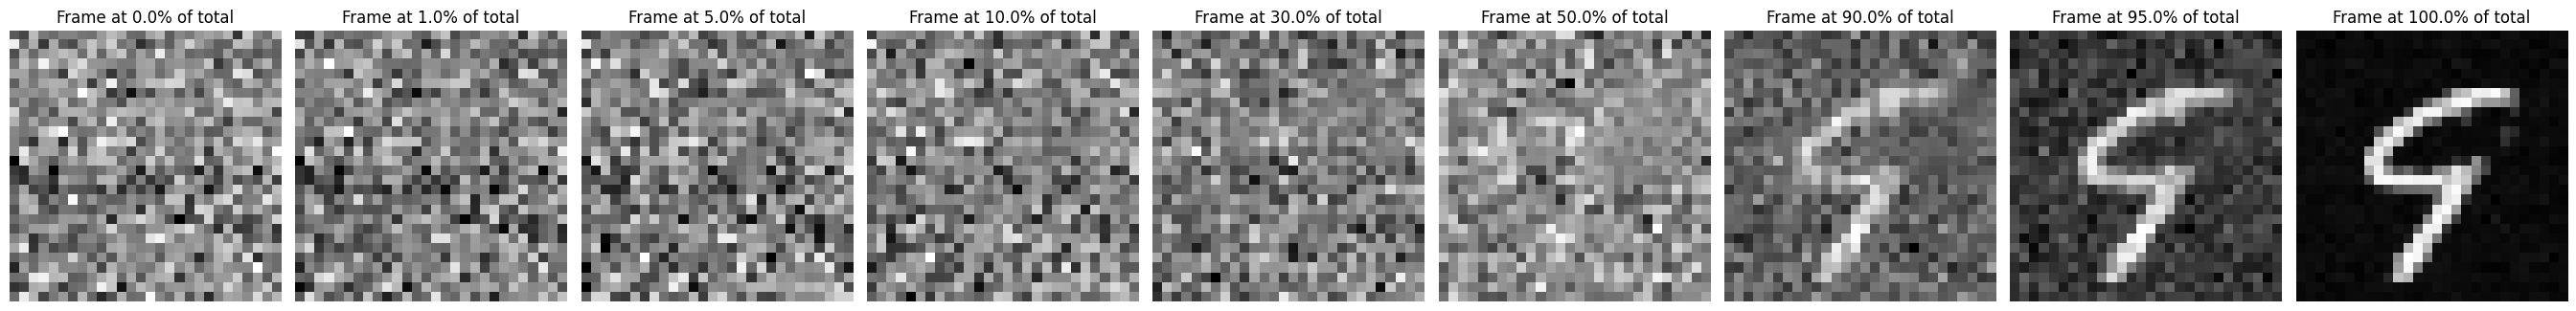

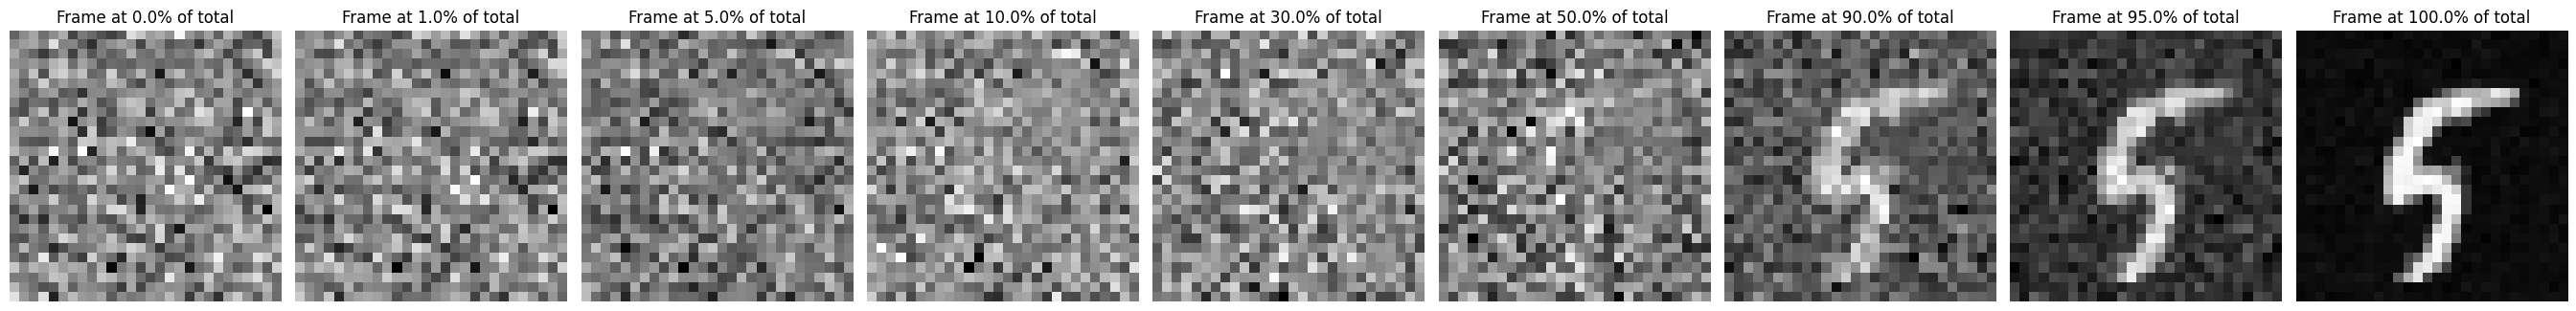

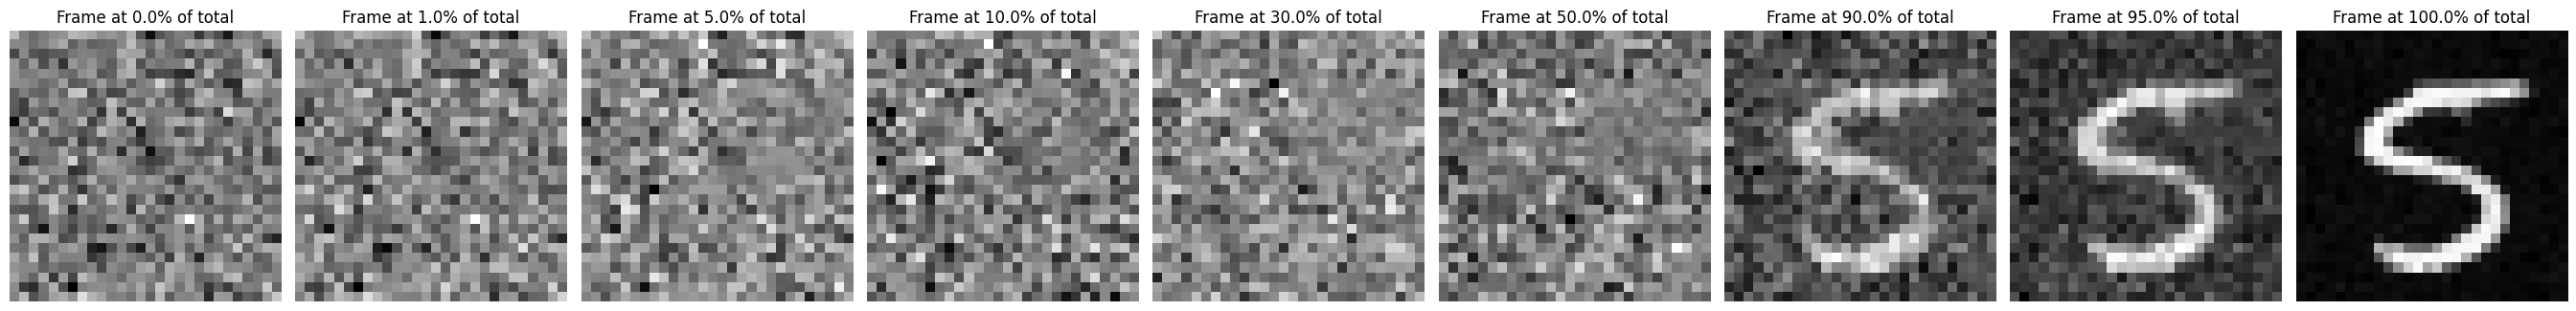

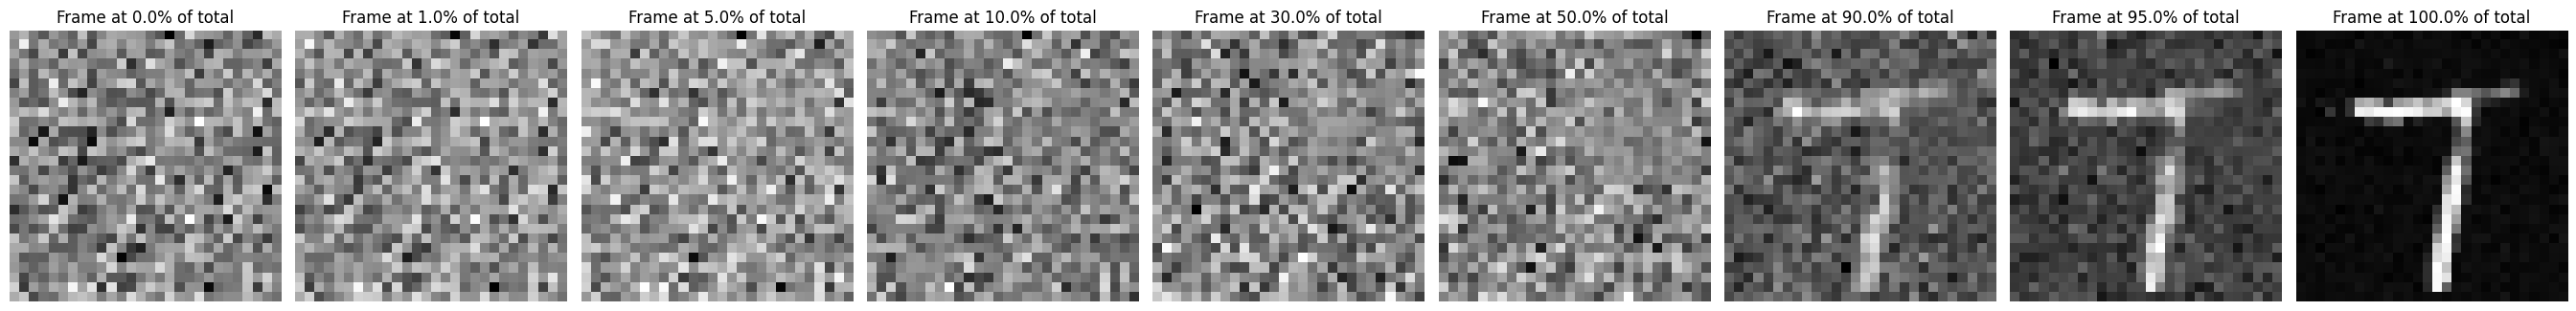

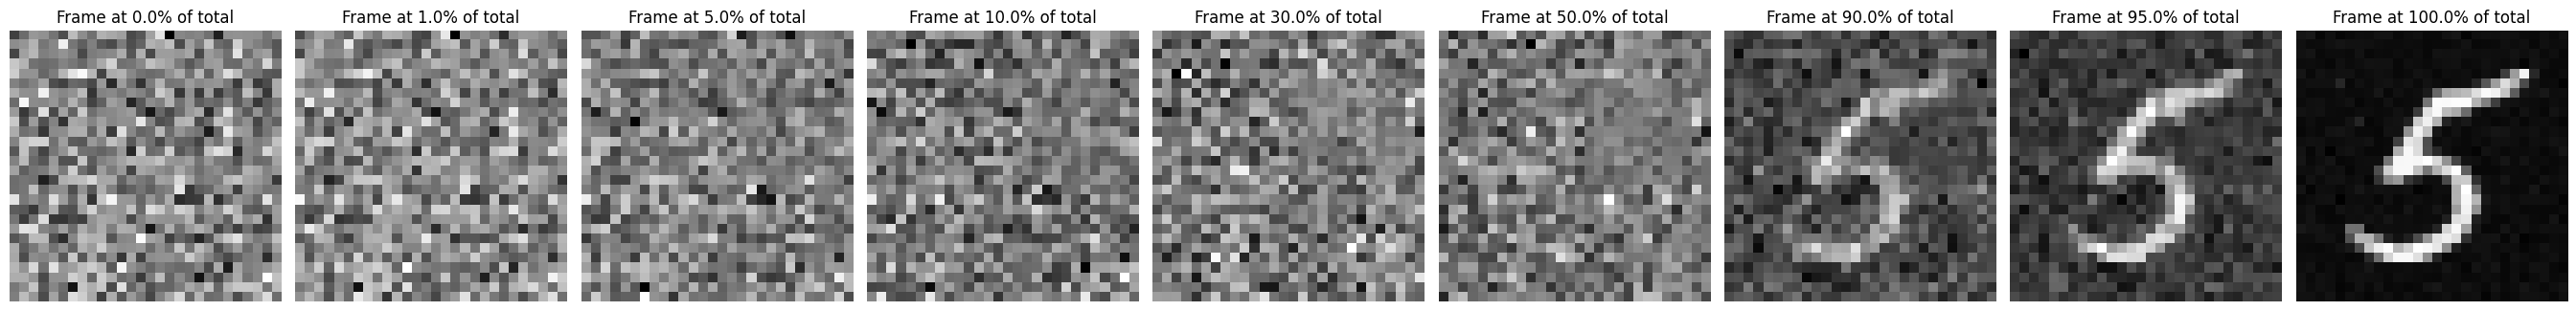

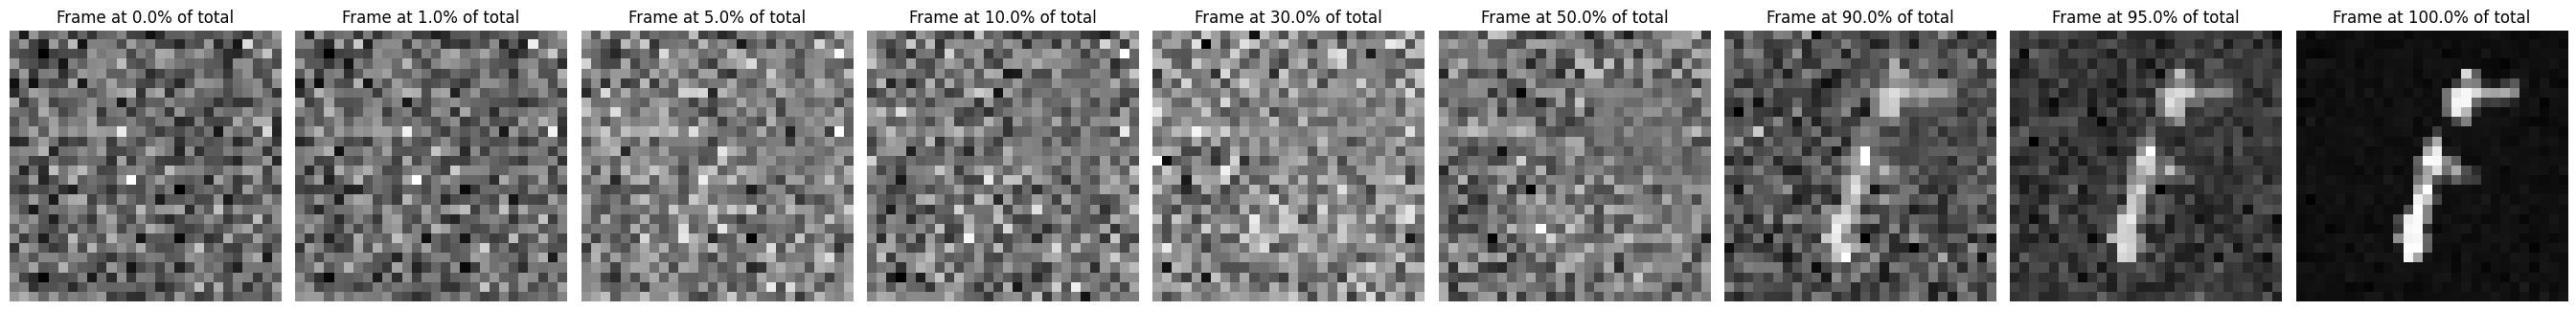

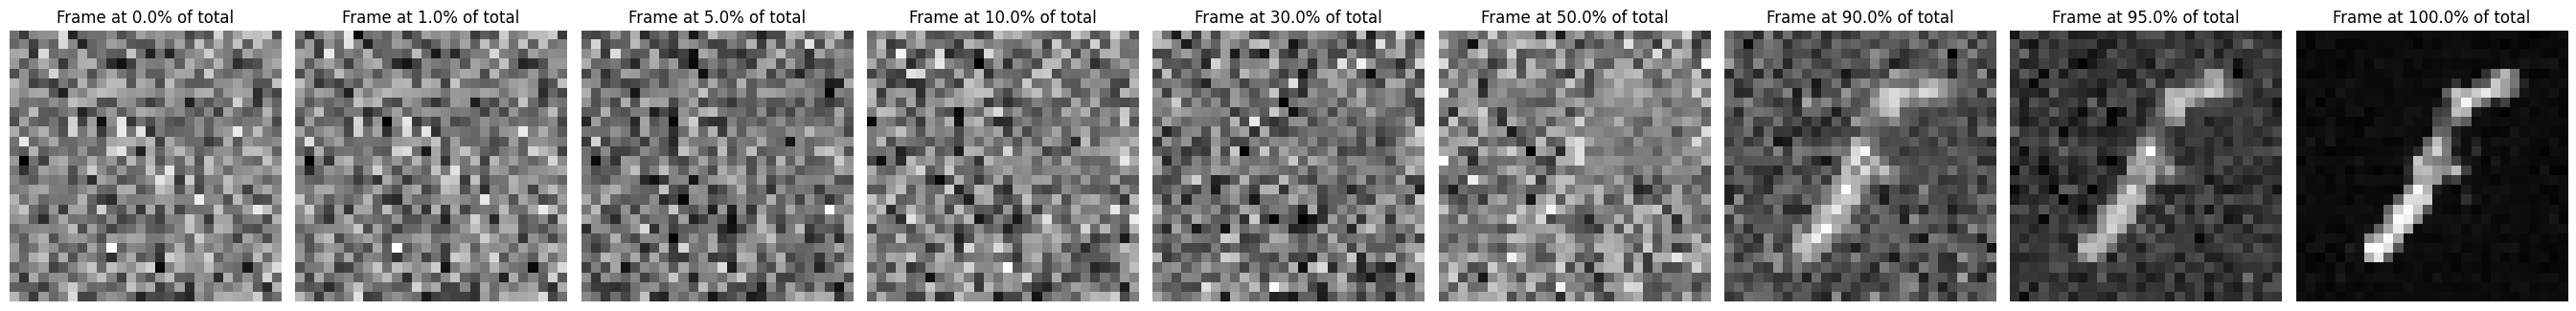

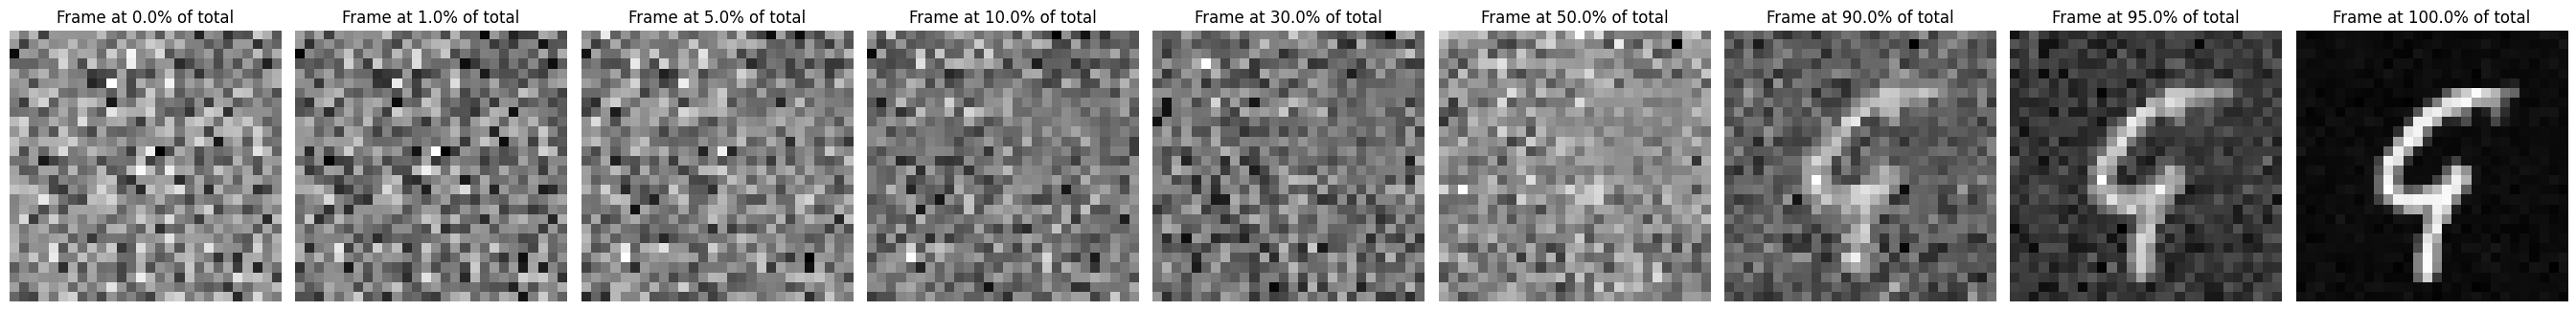

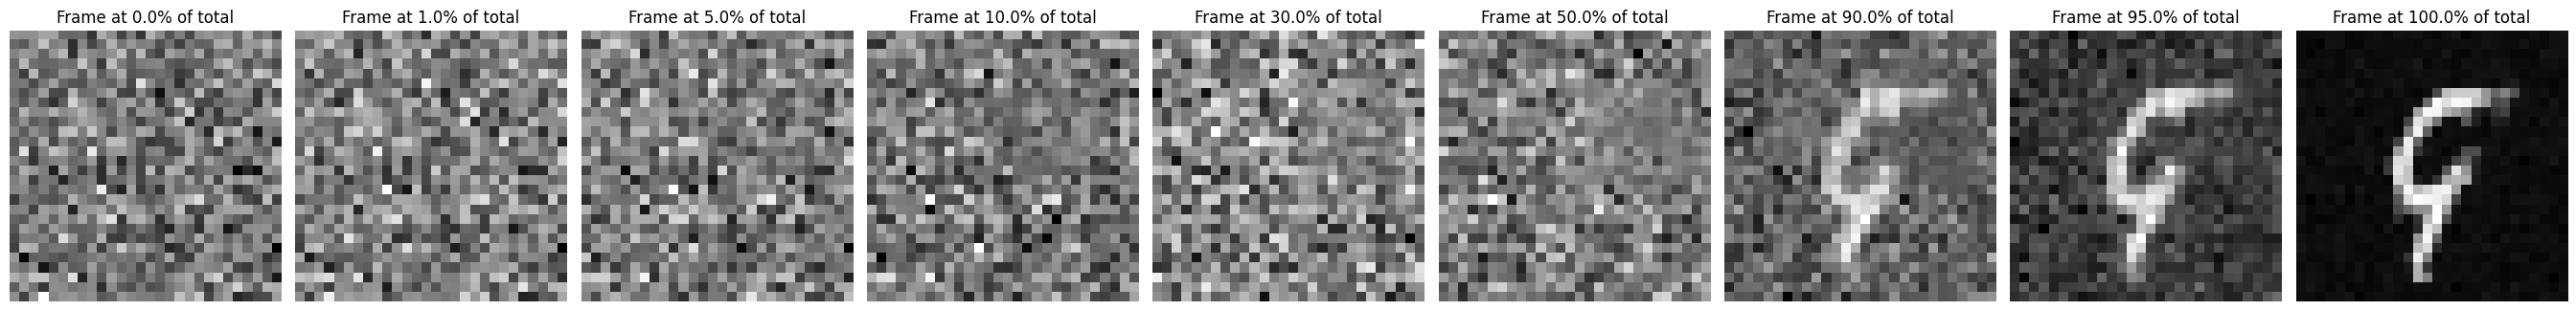

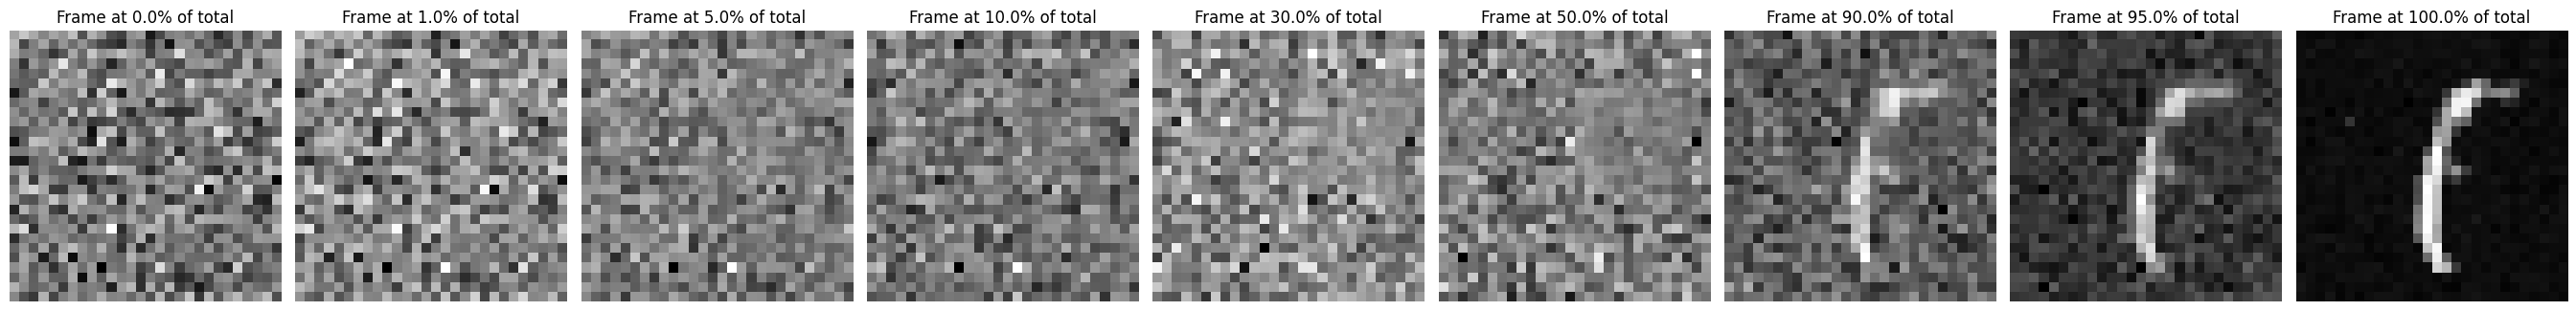

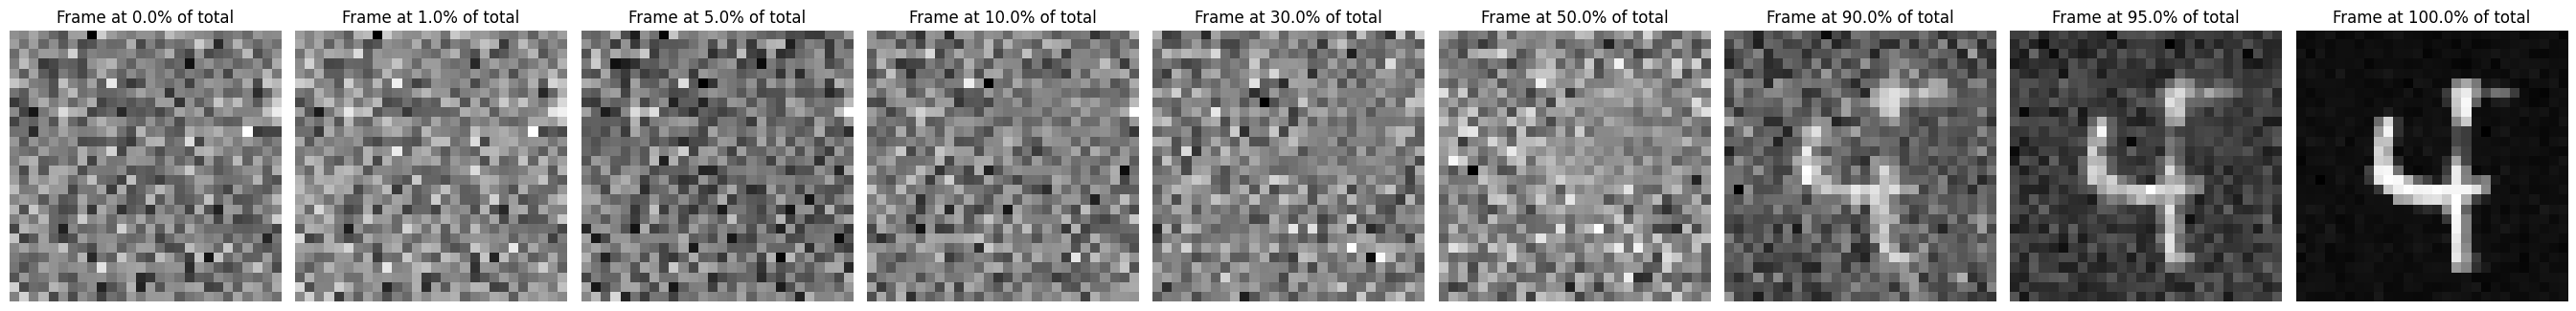

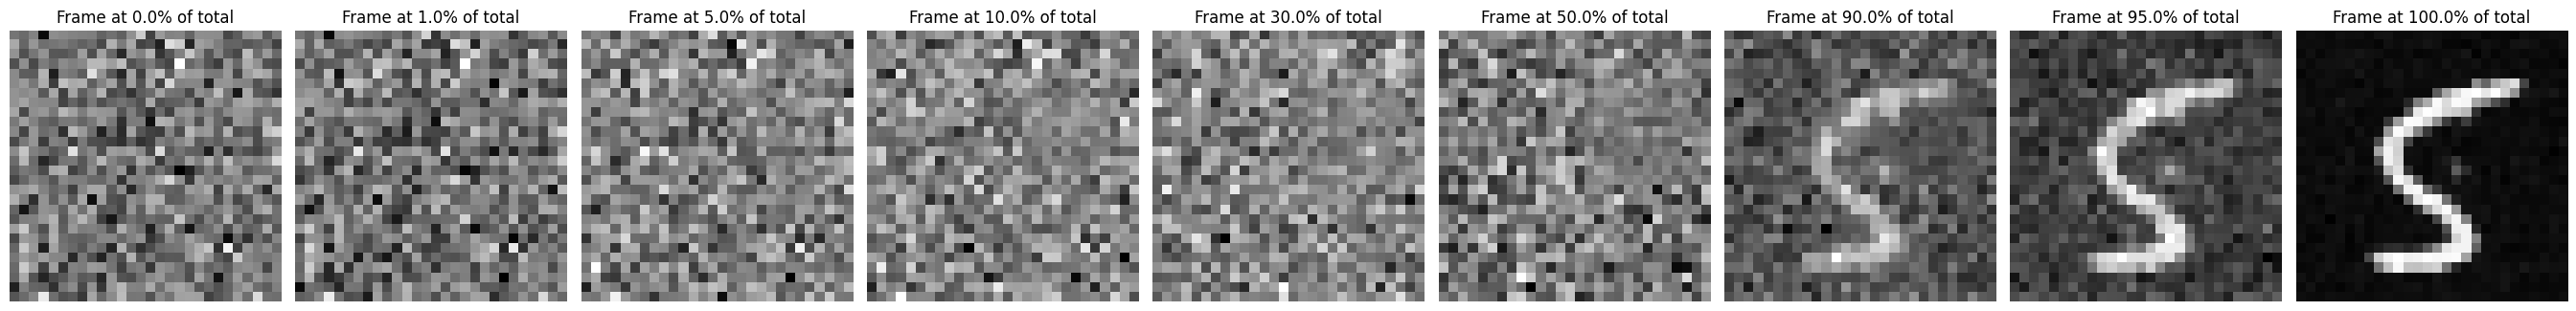

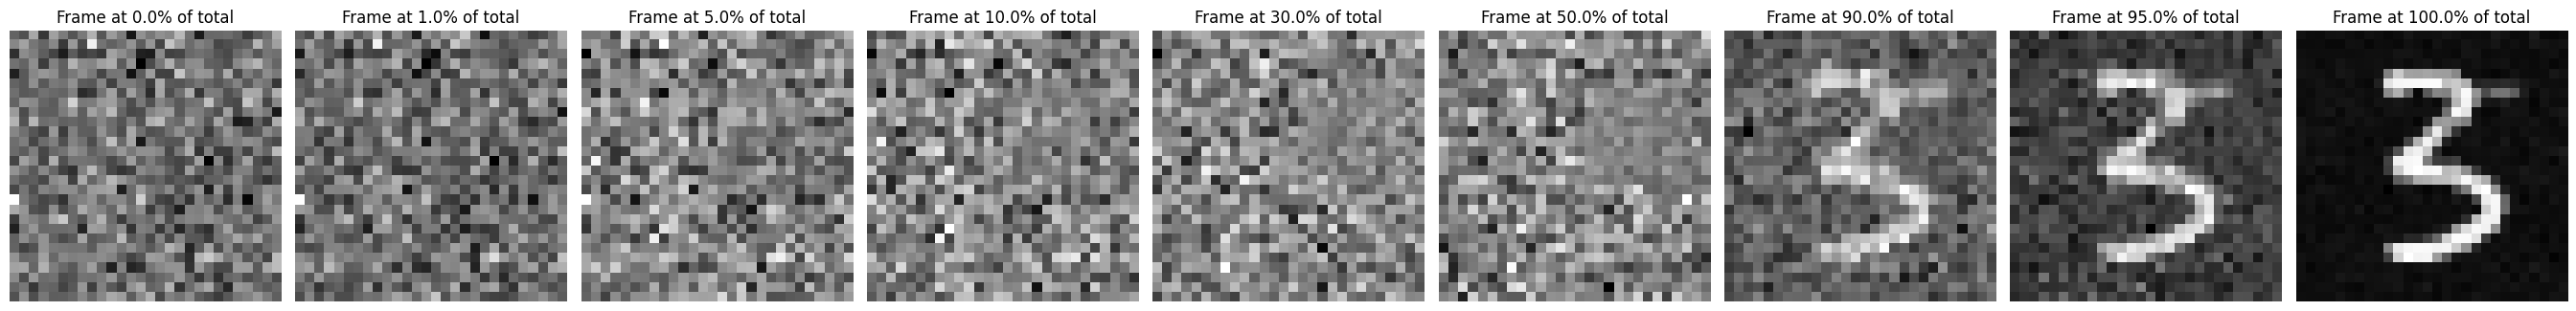

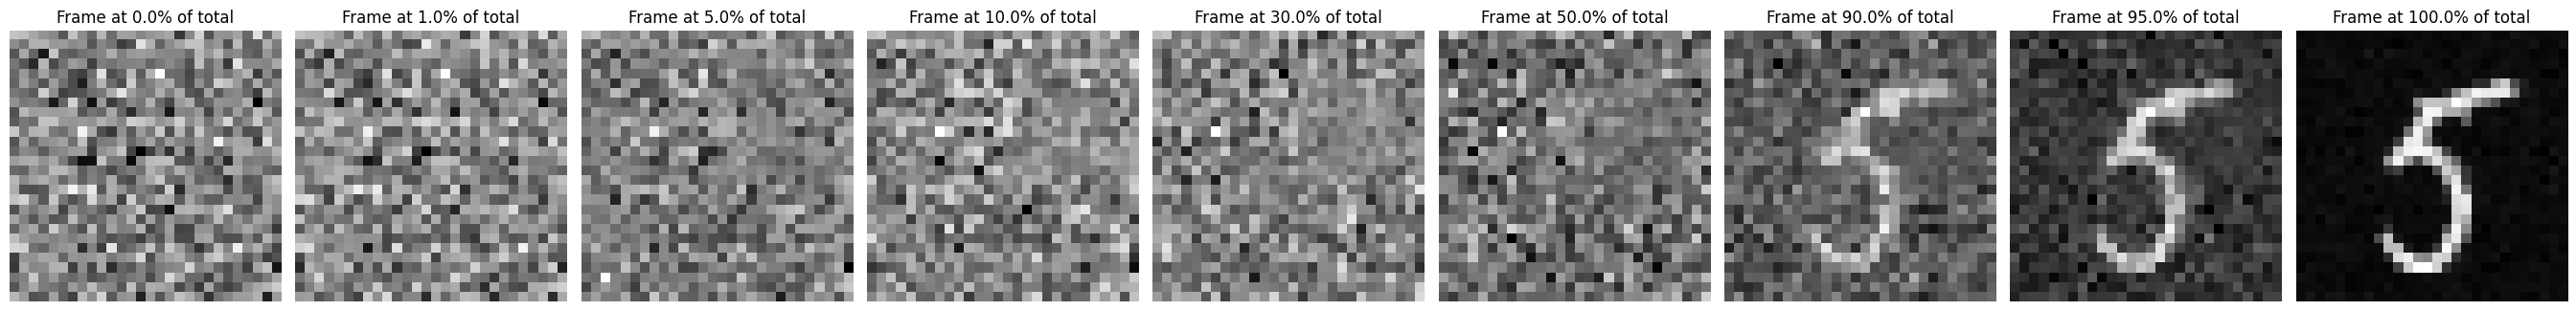

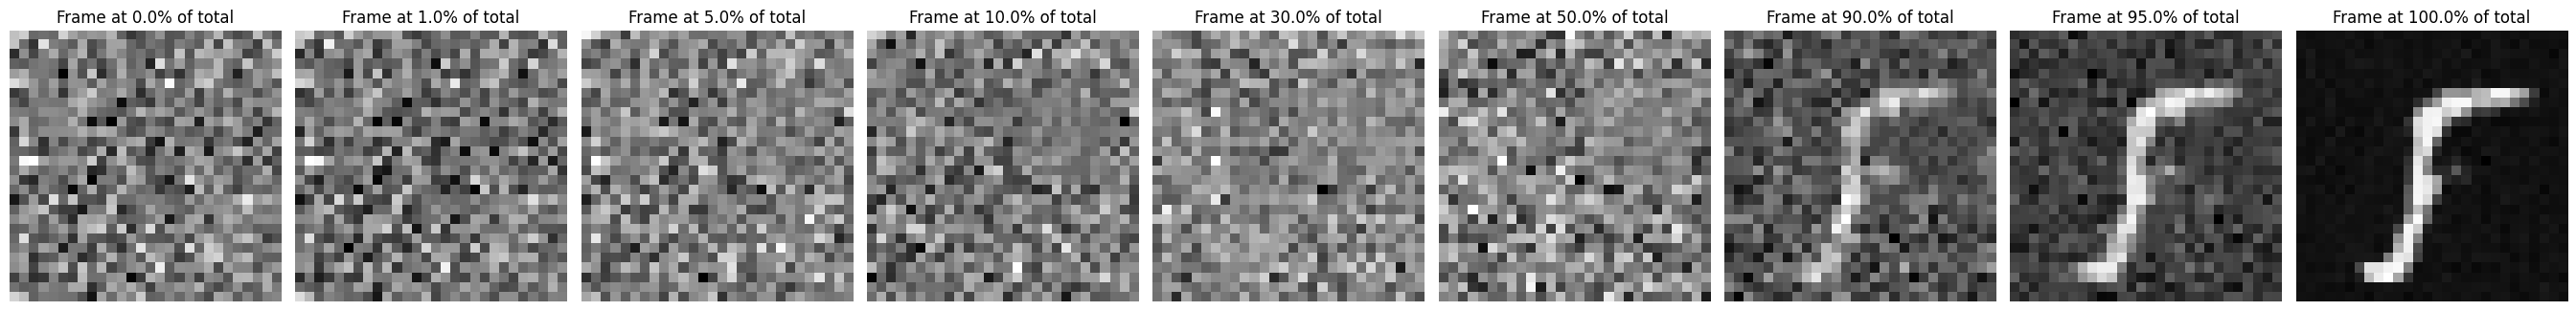

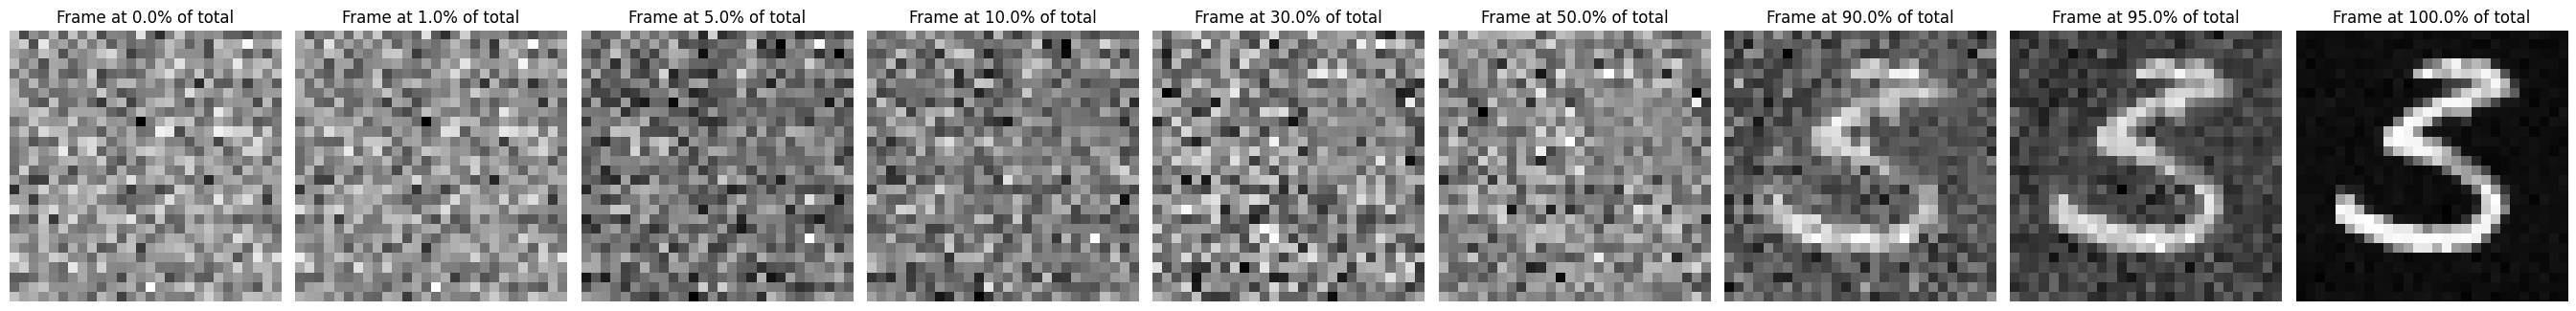

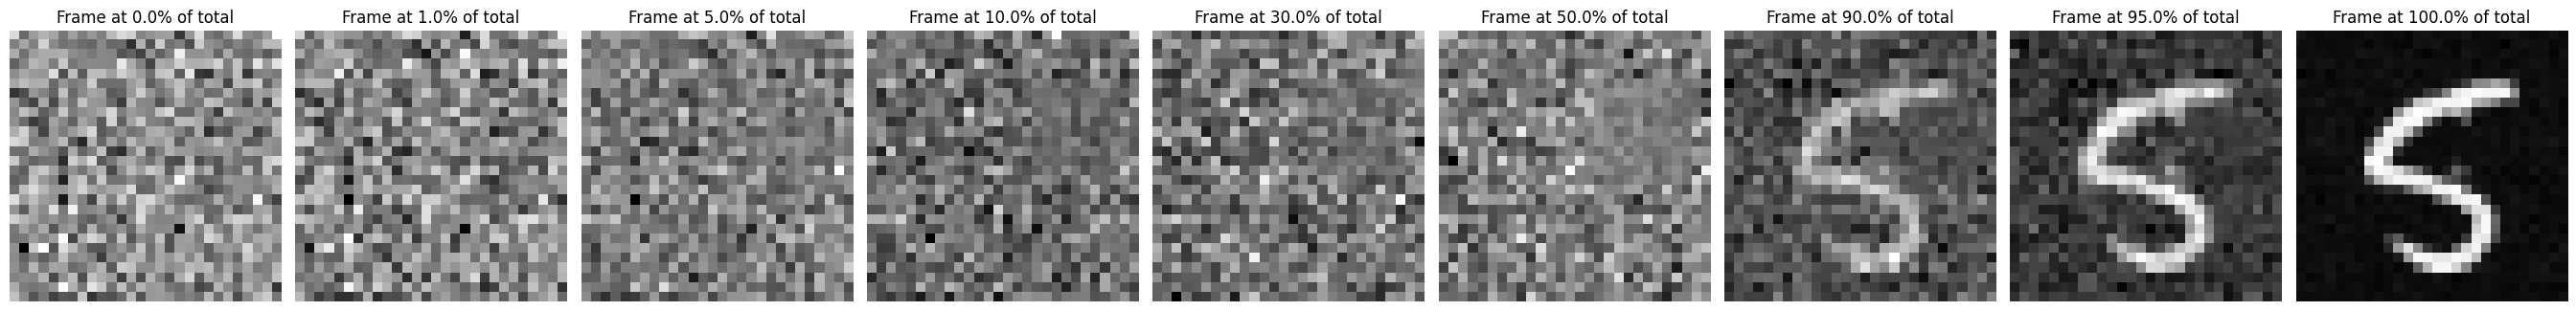

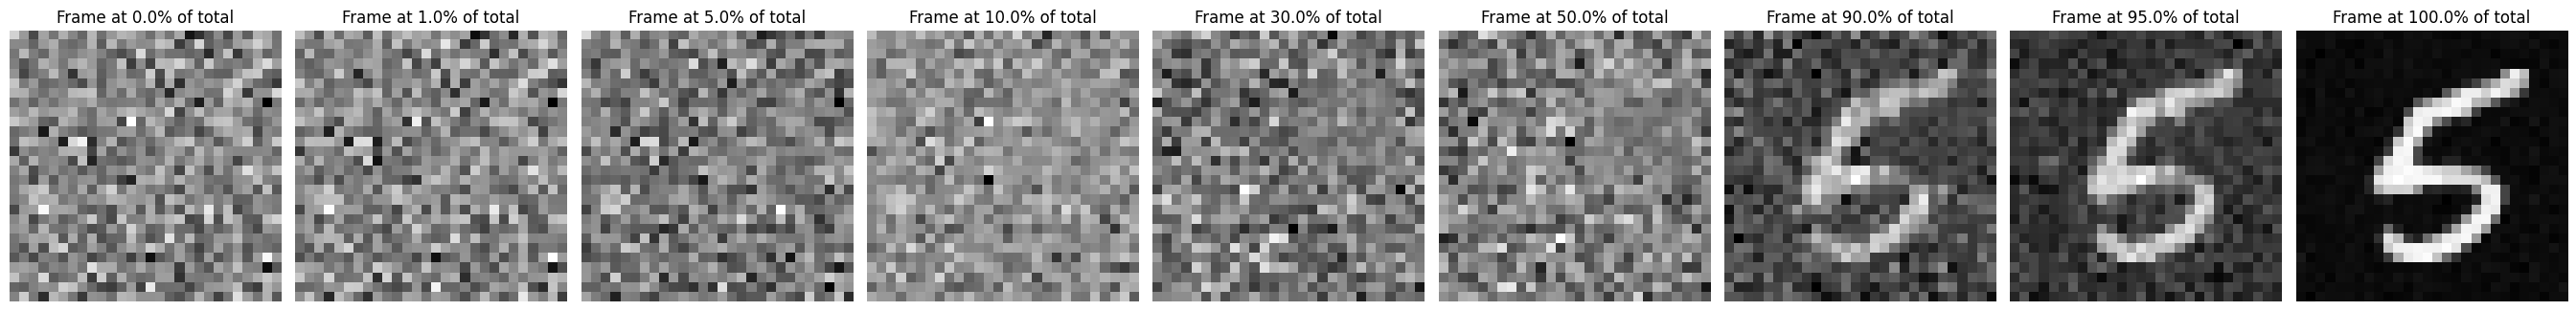

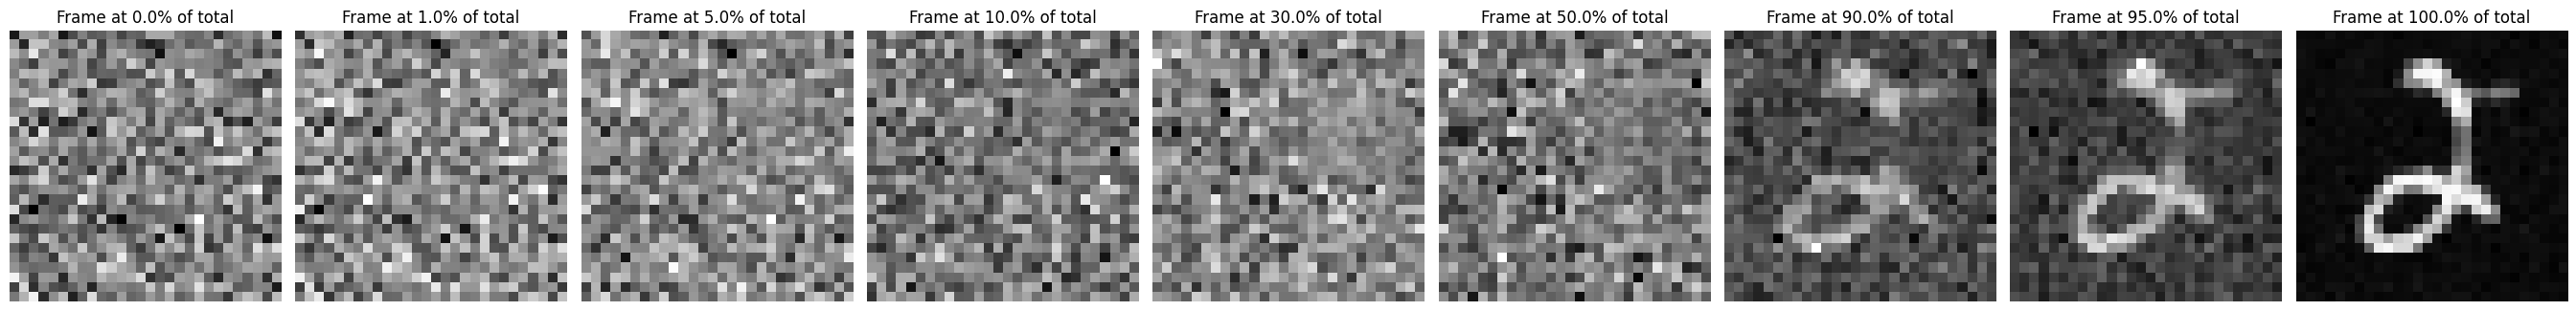

Array([ 8.566264, 10.561255], dtype=float32)

In [51]:
for i in range(10):
    plotter_line(new_state.thetas[:, i])
    plotter_line(new_state.cntrst_thetas[:, i])
new_state.xi

In [5]:
import matplotlib.pyplot as plt
def plotter_line(array):
    total_frames = len(array)

    # Define the fractions
    fractions = [0., 0.01, 0.05, .1, 0.3, 0.5, 0.9, .95, 1.]
    n = len(fractions)
    # Create a figure with subplots
    fig, axs = plt.subplots(1, n, figsize=(n*3, n))
    
    for idx, fraction in enumerate(fractions):
        # Calculate the frame index
        frame_index = int(fraction * total_frames)
        
        # Plot the image
        axs[idx].imshow(array[frame_index], cmap="gray")
        axs[idx].set_title(f"Frame at {fraction*100}% of total")
        axs[idx].axis('off')  # Turn off axis labels
        
    plt.tight_layout()
    plt.show()


def top_5_percent_indices(arr):
    n = int(len(arr) * 0.05)  # Calculate 5% of the array length
    return jnp.argsort(arr)[-n:][::-1]  # Return indices of top 5% values in descending order


def bottom_5_percent_indices(arr):
    n = max(1, int(len(arr) * 0.05))  # Calculate 5% of the array length, minimum 1
    return jnp.argsort(arr)[:n] 

# Test of the logpdf and weighting procedure

In [20]:
history_particles = res[1][0]
log_Z = res[1][1]
n_ts = 300
n_particles = 100
ts = jnp.linspace(0.0, cond_sde.tf, n_ts)
dts = jnp.diff(ts)
key_y, key_x = jax.random.split(key)

# generate path for y
y = einops.repeat(y, "... -> ts ... ", ts=n_ts)
state = SDEState(y, jnp.zeros((n_ts, 1)))
keys = jax.random.split(key_y, n_ts)
ys = jax.vmap(cond_sde.path, in_axes=(0, 0, 0))(keys, state, ts)

# u time reversal of y
us = SDEState(ys.position[::-1], ys.t)
u_0Tm = jax.tree.map(lambda x: x[:-1], us)
u_1T = jax.tree.map(lambda x: x[1:], us)

In [21]:
k = 299
particles = history_particles[k, :]
u = jax.tree.map(lambda x: x[k], u_1T)
u_next = jax.tree.map(lambda x: x[k], u_0Tm)


# weights current particles according to likelihood of observation and normalize
cond_state = CondState(particles, u.position, xi, u.t)
log_weights = jax.vmap(
    cond_sde.logpdf, in_axes=(None, CondState(0, None, None, None), None)
)(u_next.position, cond_state, dt)

In [22]:
log_weights

Array([1145.8345 ,  924.6759 ,  906.0416 , 1246.3921 , 1034.0504 ,
        880.33704, 1186.1178 , 1141.6865 , 1038.6362 , 1029.0435 ,
       1077.0522 , 1102.8093 , 1091.2717 , 1184.0679 ,  910.4164 ,
       1044.3921 ,  978.3019 , 1064.6895 , 1089.3776 , 1149.8978 ,
        948.18384, 1019.32416, 1123.5139 ,  977.94617, 1140.5366 ,
       1063.1317 , 1171.0801 , 1222.9548 ,  946.56274, 1238.1289 ,
       1061.448  , 1080.1204 , 1006.51086, 1076.1472 ,  863.5054 ,
       1133.5493 , 1177.1106 , 1093.6565 , 1013.17957, 1081.7134 ,
       1035.4634 , 1116.5232 , 1136.819  , 1115.8643 , 1057.916  ,
       1082.9375 , 1114.3263 , 1107.5596 , 1175.6675 , 1071.895  ,
        886.25977, 1118.058  , 1250.2485 ,  855.9016 , 1047.7777 ,
       1009.7986 ,  940.6026 , 1226.4108 , 1116.9717 , 1108.4926 ,
       1229.4905 , 1196.2495 , 1026.1775 ,  978.1278 , 1009.7055 ,
       1153.0834 , 1016.3618 , 1026.7069 ,  898.9852 , 1273.9877 ,
        999.7091 , 1037.851  , 1019.0381 , 1112.0059 , 1180.74

In [23]:
_norm = jax.scipy.special.logsumexp(log_weights, axis=0)
log_weights = log_weights - _norm

In [24]:
np.exp(log_weights)

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0360755e-12,
       0.0000000e+00, 0.0000000e+00, 6.8960280e-39, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 8.8782487e-40, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 1.4012985e-45, 6.8662649e-23,
       0.0000000e+00, 2.6713844e-16, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       8.4498297e-43, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       1.9898438e-43, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       4.9003194e-11, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 2.1757702e-21, 0.0000000e+00, 0.0000000e

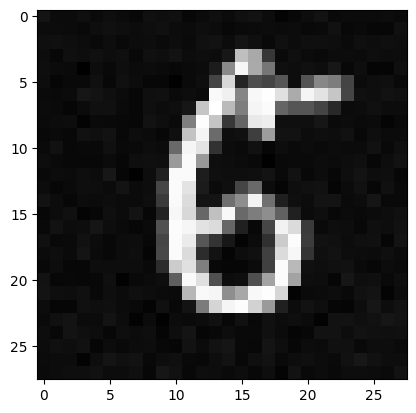

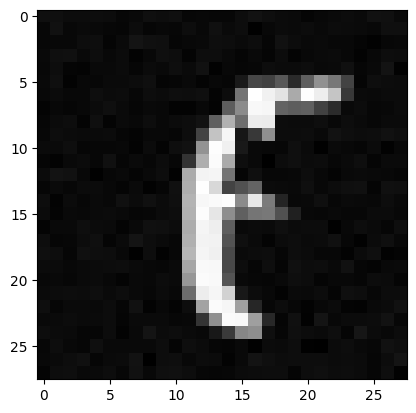

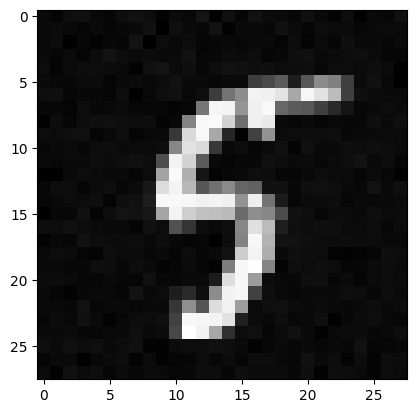

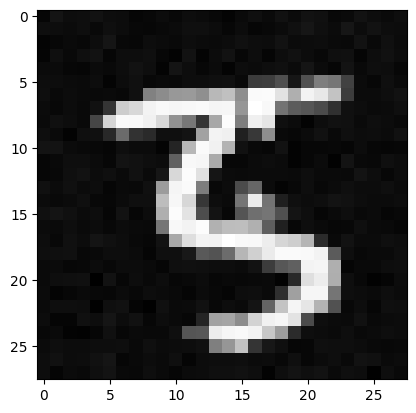

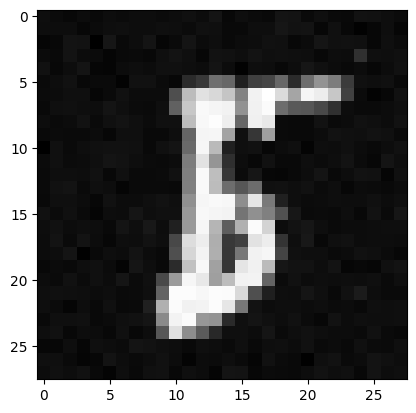

In [25]:
idx = top_5_percent_indices(np.exp(log_weights))
for i in idx:
    plt.imshow(particles[i], cmap="gray")
    plt.show()

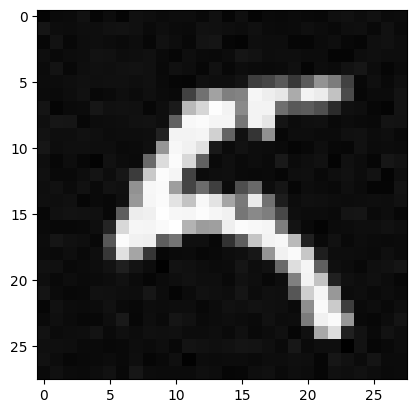

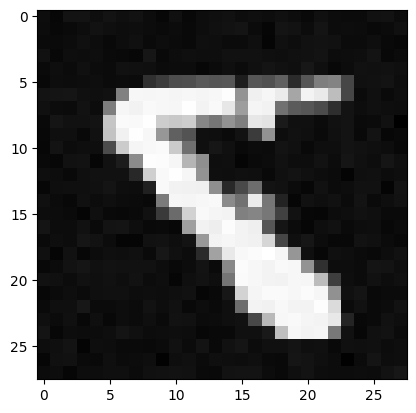

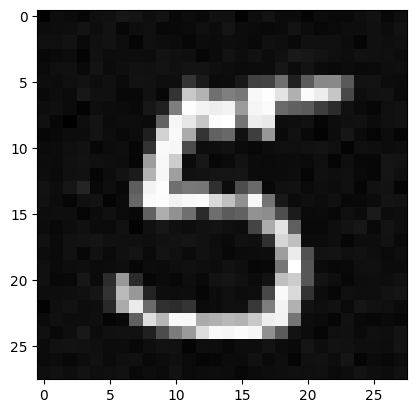

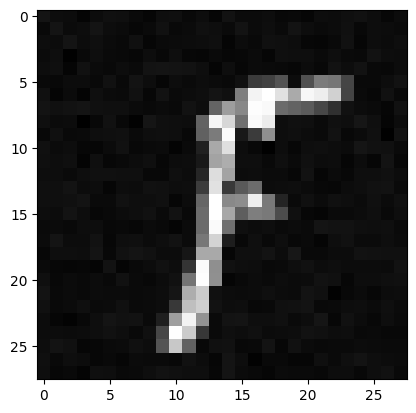

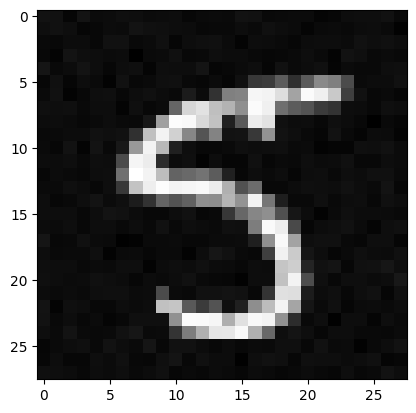

In [26]:
idx = bottom_5_percent_indices(np.exp(log_weights))
for i in idx:
    plt.imshow(particles[i], cmap="gray")
    plt.show()

In [19]:
log_Z = res[1][1]


In [20]:
log_Z.shape

(299,)